In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn import svm
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import time
import pickle 
from pprint import pprint
import warnings
warnings.filterwarnings('ignore')

# Package for XGBoost
from xgboost import XGBClassifier
import torch

import shap


In [10]:
df_time = pd.read_csv("Data/Data Sets/Processing Time Data.csv")
df_time = df_time.loc[:94]
df_time = df_time.astype(int, errors='ignore')
df_time['MONTH_YEAR'] = pd.to_datetime(df_time['YEAR'].astype(int).astype(str) + '-' + df_time['MONTH'].astype(int).astype(str), format='%Y-%m')
df_time['CHINA_DATE'] = pd.to_datetime(df_time['CHINA YEAR'].astype(int).astype(str) + '-' + df_time['CHINA MONTH'].astype(int).astype(str), format='%Y-%m')
df_time['INDIA_DATE'] = pd.to_datetime(df_time['INDIA YEAR'].astype(int).astype(str) + '-' + df_time['INDIA MONTH'].astype(int).astype(str), format='%Y-%m')
df_time['MEXICO_DATE'] = pd.to_datetime(df_time['MEXICO YEAR'].astype(int).astype(str) + '-' + df_time['MEXICO MONTH'].astype(int).astype(str), format='%Y-%m')
df_time['PHILIPPINES_DATE'] = pd.to_datetime(df_time['PHILIPPINES YEAR'].astype(int).astype(str) + '-' + df_time['PHILIPPINES MONTH'].astype(int).astype(str), format='%Y-%m')
df_time['ALL_DATE'] = pd.to_datetime(df_time['ALL YEAR'].astype(int).astype(str) + '-' + df_time['ALL MONTH'].astype(int).astype(str), format='%Y-%m')
df_time = df_time.drop(columns=['MONTH','YEAR','CHINA MONTH','CHINA YEAR','INDIA MONTH','INDIA YEAR','MEXICO MONTH','MEXICO YEAR','PHILIPPINES MONTH','PHILIPPINES YEAR','ALL YEAR','ALL MONTH'])
df_time

,MONTH_YEAR,CHINA_DATE,INDIA_DATE,MEXICO_DATE,PHILIPPINES_DATE,ALL_DATE
0,2023-11-01,2020-09-01,2012-08-01,2023-02-01,2023-01-01,2023-02-01
1,2023-10-01,2020-09-01,2012-08-01,2023-02-01,2023-01-01,2023-02-01
2,2023-09-01,2019-11-01,2012-08-01,2023-05-01,2023-05-01,2023-05-01
3,2023-08-01,2019-09-01,2012-08-01,2023-05-01,2023-05-01,2023-05-01
4,2023-07-01,2019-06-01,2012-08-01,2023-05-01,2023-05-01,2023-05-01
...,...,...,...,...,...,...
90,2016-05-01,2015-05-01,2005-07-01,2016-05-01,2010-01-01,2016-05-01
91,2016-04-01,2015-05-01,2005-07-01,2016-04-01,2010-01-01,2016-04-01
92,2016-03-01,2015-05-01,2005-07-01,2016-03-01,2010-01-01,2016-03-01
93,2016-02-01,2013-10-01,2005-07-01,2016-01-01,2010-01-01,2016-01-01


In [11]:
df = pd.read_csv('Data/Data Sets/PERM_Data.csv')

In [12]:
# Data cleaning

columns_to_drop = ['CASE_NO', 'CASE_STATUS', 'PW_SOC_CODE', 'JOB_INFO_WORK_CITY', 'PW_DETERM_DATE', 'PW_EXPIRE_DATE', 'JOB_INFO_MAJOR', 'JI_OFFERED_TO_SEC_J_FOREIGN_WORKER', 'RECR_INFO_PROFESSIONAL_OCC', 'FOREIGN_WORKER_INFO_MAJOR', 'CASE_RECEIVED_MONTH','CASE_RECEIVED_YEAR']

df.drop(columns=columns_to_drop, inplace=True)


conversion_factors = {
    'Bi-Weekly': 26,  # Assuming 52 weeks in a year and bi-weekly pay
    'Hour': 2080,     # Assuming 40 hours per week and 52 weeks in a year
    'Month': 12,      # Monthly pay
    'Week': 52        # Weekly pay
}

# Convert salaries to annual salary where unit of pay is not 'Year'
for index, row in df.iterrows():
    if row['PW_UNIT_OF_PAY_9089'] != 'Year':
        conversion_factor = conversion_factors.get(row['PW_UNIT_OF_PAY_9089'])
        if conversion_factor:
            df.at[index, 'PW_AMOUNT_9089'] *= conversion_factor

df.drop(columns=['PW_UNIT_OF_PAY_9089'], inplace=True)

# Convert 'PW_AMOUNT_9089' column to numeric
df['PW_AMOUNT_9089'] = pd.to_numeric(df['PW_AMOUNT_9089'], errors='coerce')

# Identify values under 1000 in the 'PW_AMOUNT_9089' column
under_1000 = df['PW_AMOUNT_9089'] < 1000

# Multiply values under 1000 by 1000
df.loc[under_1000, 'PW_AMOUNT_9089'] *= 1000

# Replace incorrect values in the 'JOB_INFO_WORK_STATE' column
df['JOB_INFO_WORK_STATE'].replace({'MASSACHUSETTES': 'MASSACHUSETTS', 'MH': 'MARSHALL ISLANDS'}, inplace=True)

# Replace incorrect values in the 'COUNTRY_OF_CITIZENSHIP' column
df['COUNTRY_OF_CITIZENSHIP'].replace({'IVORY COAST': "COTE d'IVOIRE", 'NETHERLANDS ANTILLES': 'NETHERLANDS'}, inplace=True)

# Drop rows with specified values in the 'COUNTRY_OF_CITIZENSHIP' column
df = df[~df['COUNTRY_OF_CITIZENSHIP'].isin(['SOVIET UNION', 'UNITED STATES OF AMERICA'])]

df.dropna(axis=0, how='any', inplace=True)


In [13]:
df['CASE_RECEIVED_DATE'] = pd.to_datetime(df['CASE_RECEIVED_DATE'], errors = 'coerce')
df['DECISION_DATE'] = pd.to_datetime(df['DECISION_DATE'], errors = 'coerce')

# Calculate the number of months between the two dates
df['MONTHS_TO_DECISION'] = (df['DECISION_DATE'].dt.year - df['CASE_RECEIVED_DATE'].dt.year) * 12 + (df['DECISION_DATE'].dt.month - df['CASE_RECEIVED_DATE'].dt.month)

df['DECISION_DATE'] = pd.to_datetime(df['DECISION_DATE']).dt.to_period('M').dt.to_timestamp()
df['CASE_RECEIVED_DATE'] = pd.to_datetime(df['CASE_RECEIVED_DATE']).dt.to_period('M').dt.to_timestamp()
df = df.reset_index(drop=True)

df_china = df[df['COUNTRY_OF_CITIZENSHIP'] == 'CHINA']
df_china = df_china.reset_index(drop=True)
df_india = df[df['COUNTRY_OF_CITIZENSHIP'] == 'INDIA']
df_india = df_india.reset_index(drop=True)
df_mexico = df[df['COUNTRY_OF_CITIZENSHIP'] == 'MEXICO']
df_mexico = df_mexico.reset_index(drop=True)
df_philippines = df[df['COUNTRY_OF_CITIZENSHIP'] == 'PHILIPPINES']
df_philippines = df_philippines.reset_index(drop=True)

countries_to_exclude = ['INDIA', 'CHINA', 'MEXICO', 'PHILIPPINES']
df_all = df[~df['COUNTRY_OF_CITIZENSHIP'].isin(countries_to_exclude)]
df_all = df_all.reset_index(drop=True)

df_china = pd.merge(df_time, df_china, left_on='MONTH_YEAR', right_on='CASE_RECEIVED_DATE', how='inner', suffixes=('', '_CHINA'))
df_india = pd.merge(df_time, df_india, left_on='MONTH_YEAR', right_on='CASE_RECEIVED_DATE', how='inner', suffixes=('', '_INDIA'))
df_mexico = pd.merge(df_time, df_mexico, left_on='MONTH_YEAR', right_on='CASE_RECEIVED_DATE', how='inner', suffixes=('', '_MEXICO'))
df_philippines = pd.merge(df_time, df_philippines, left_on='MONTH_YEAR', right_on='CASE_RECEIVED_DATE', how='inner', suffixes=('', '_PHILIPPINES'))
df_all = pd.merge(df_time, df_all, left_on='MONTH_YEAR', right_on='CASE_RECEIVED_DATE', how='inner', suffixes=('', '_ALL'))

# Calculate waiting time in months
df_china['WAITING_TIME'] = (df_china['DECISION_DATE'] - df_china['CHINA_DATE']).dt.days // 30
df_india['WAITING_TIME'] = (df_india['DECISION_DATE'] - df_india['INDIA_DATE']).dt.days // 30
df_mexico['WAITING_TIME'] = (df_mexico['DECISION_DATE'] - df_mexico['MEXICO_DATE']).dt.days // 30
df_philippines['WAITING_TIME'] = (df_philippines['DECISION_DATE'] - df_philippines['PHILIPPINES_DATE']).dt.days // 30
df_all['WAITING_TIME'] = (df_all['DECISION_DATE'] - df_all['ALL_DATE']).dt.days // 30

df_china = df_china.drop(columns=['MONTH_YEAR','INDIA_DATE','MEXICO_DATE','PHILIPPINES_DATE','ALL_DATE'])
df_india = df_india.drop(columns=['MONTH_YEAR','CHINA_DATE','MEXICO_DATE','PHILIPPINES_DATE','ALL_DATE'])
df_mexico = df_mexico.drop(columns=['MONTH_YEAR','CHINA_DATE','INDIA_DATE','PHILIPPINES_DATE','ALL_DATE'])
df_philippines = df_philippines.drop(columns=['MONTH_YEAR','CHINA_DATE','INDIA_DATE','MEXICO_DATE','ALL_DATE'])
df_all = df_all.drop(columns=['MONTH_YEAR','CHINA_DATE','INDIA_DATE','MEXICO_DATE','PHILIPPINES_DATE'])

df_china.dropna(subset=['WAITING_TIME'], inplace=True)
df_india.dropna(subset=['WAITING_TIME'], inplace=True)
df_mexico.dropna(subset=['WAITING_TIME'], inplace=True)
df_philippines.dropna(subset=['WAITING_TIME'], inplace=True)
df_all.dropna(subset=['WAITING_TIME'], inplace=True)

df_combined = pd.concat([df_china, df_india, df_mexico, df_philippines, df_all], ignore_index=True)
df_combined.rename(columns={'2_NAICS': 'NAICS'}, inplace=True)

In [14]:
# Define waiting time ranges in months
waiting_time_ranges = [(0, 30), (30, 60), (60, 120), (120, float('inf'))]  # float('inf') for 10+ years

# Define waiting time labels in years
waiting_time_labels = ['0-2.5 years', '2.5-5 years', '5-10 years', '>10 years']

# Function to categorize waiting time into ranges
def categorize_waiting_time(waiting_time):
    for i, (start, end) in enumerate(waiting_time_ranges):
        if start <= waiting_time < end:
            return waiting_time_labels[i]
    return waiting_time_labels[-1] 

In [19]:
# Apply categorization to waiting time and assign to y
df_combined['WAITING_TIME_RANGE'] = df_combined['WAITING_TIME'].apply(categorize_waiting_time)
y = df_combined['WAITING_TIME_RANGE']

In [ ]:
from sklearn.preprocessing import StandardScaler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
# Prepare data for training
X = df_combined.drop(columns=['MONTHS_TO_DECISION', 'WAITING_TIME', 'DECISION_DATE', 'CASE_RECEIVED_DATE', 'CHINA_DATE', 'INDIA_DATE','MEXICO_DATE','PHILIPPINES_DATE','ALL_DATE', 'WAITING_TIME_RANGE'])
cat_var = ['NAICS', 'PW_LEVEL_9089', 'JOB_INFO_WORK_STATE', 'COUNTRY_OF_CITIZENSHIP', 'FOREIGN_WORKER_INFO_EDUCATION', 'JOB_INFO_EXPERIENCE', 'CLASS_OF_ADMISSION', 'JOB_INFO_EDUCATION', 'JOB_INFO_TRAINING', 'JOB_INFO_FOREIGN_ED', 'RI_LAYOFF_IN_PAST_SIX_MONTHS', 'FW_INFO_REQ_EXPERIENCE']
X_encoded = pd.get_dummies(X, columns=cat_var)
category_mapping = {
    "0-2.5 years": 0,
    "2.5-5 years": 1,
    "5-10 years": 2,
    ">10 years": 3
}
y = np.vectorize(category_mapping.get)(y)
X_encoded = X_encoded.astype(int)

# Standardize features
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X_encoded)

X_tensor = torch.tensor(X_normalized, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y, dtype=torch.float32).to(device)

# Split data into training and testing sets
train_X, test_X, train_y, test_y = train_test_split(X_tensor, y_tensor, test_size=0.25, random_state=27)

Using device: cpu


In [10]:
''''X.to_csv('immigration_data.csv', index=False)
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Auto width
pd.set_option('display.max_colwidth', None)  #
print(train_X.dtypes)''''


PW_AMOUNT_9089                                             float64
EMPLOYER_NUM_EMPLOYEES                                       int64
JOB_INFO_EXPERIENCE_NUM_MONTHS                               int64
FW_INFO_YR_REL_EDU_COMPLETED                                 int64
NAICS_11                                                      bool
NAICS_21                                                      bool
NAICS_22                                                      bool
NAICS_23                                                      bool
NAICS_31                                                      bool
NAICS_32                                                      bool
NAICS_33                                                      bool
NAICS_42                                                      bool
NAICS_44                                                      bool
NAICS_45                                                      bool
NAICS_48                                                      

NEURAL NET NEURAL NET NEURAL NET NEURAL NET NEURAL NET


[0. 3. 0. ... 0. 0. 1.]
(378804, 356) (378804,)
(126269, 356) (126269,)
Epoch 1/50


2024-12-13 21:09:47.318173: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [32] vs. [32,4]
	 [[{{function_node __inference_one_step_on_data_7235}}{{node gradient_tape/compile_loss/mean_squared_error/sub/BroadcastGradientArgs}}]]


InvalidArgumentError: Graph execution error:

Detected at node gradient_tape/compile_loss/mean_squared_error/sub/BroadcastGradientArgs defined at (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/runpy.py", line 86, in _run_code

  File "/Users/gavinlynch04/PycharmProjects/GreenCardResearch/.venv/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/Users/gavinlynch04/PycharmProjects/GreenCardResearch/.venv/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/Users/gavinlynch04/PycharmProjects/GreenCardResearch/.venv/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/Users/gavinlynch04/PycharmProjects/GreenCardResearch/.venv/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/asyncio/base_events.py", line 600, in run_forever

  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/asyncio/base_events.py", line 1896, in _run_once

  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/Users/gavinlynch04/PycharmProjects/GreenCardResearch/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/Users/gavinlynch04/PycharmProjects/GreenCardResearch/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/Users/gavinlynch04/PycharmProjects/GreenCardResearch/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/Users/gavinlynch04/PycharmProjects/GreenCardResearch/.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/Users/gavinlynch04/PycharmProjects/GreenCardResearch/.venv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/Users/gavinlynch04/PycharmProjects/GreenCardResearch/.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/Users/gavinlynch04/PycharmProjects/GreenCardResearch/.venv/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/Users/gavinlynch04/PycharmProjects/GreenCardResearch/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/Users/gavinlynch04/PycharmProjects/GreenCardResearch/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/Users/gavinlynch04/PycharmProjects/GreenCardResearch/.venv/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/Users/gavinlynch04/PycharmProjects/GreenCardResearch/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/Users/gavinlynch04/PycharmProjects/GreenCardResearch/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/Users/gavinlynch04/PycharmProjects/GreenCardResearch/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/var/folders/g6/0zwbn3ys1sn1cfb8s33n2nf40000gn/T/ipykernel_76714/1254457047.py", line 25, in <module>

  File "/Users/gavinlynch04/PycharmProjects/GreenCardResearch/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/gavinlynch04/PycharmProjects/GreenCardResearch/.venv/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 368, in fit

  File "/Users/gavinlynch04/PycharmProjects/GreenCardResearch/.venv/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 216, in function

  File "/Users/gavinlynch04/PycharmProjects/GreenCardResearch/.venv/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 129, in multi_step_on_iterator

  File "/Users/gavinlynch04/PycharmProjects/GreenCardResearch/.venv/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 110, in one_step_on_data

  File "/Users/gavinlynch04/PycharmProjects/GreenCardResearch/.venv/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 75, in train_step

Incompatible shapes: [32] vs. [32,4]
	 [[{{node gradient_tape/compile_loss/mean_squared_error/sub/BroadcastGradientArgs}}]] [Op:__inference_multi_step_on_iterator_7288]

DECISION TREE DECISION TREE DECISION TREE DECISION TREE DECISION TREE DECISION TREE DECISION TREE DECISION TREE DECISION TREE

In [39]:
mtry_fraction = 0.5  # Mtry as a fraction of the total number of predictors (0.005 seems to be best)

# Calculate the actual Mtry value based on the fraction
num_predictors = len(train_X.columns)
mtry = int(np.ceil(mtry_fraction * num_predictors))

# Best Tree
bestClassTree = DecisionTreeClassifier(max_depth=68, max_features=None, min_samples_leaf=2, min_samples_split=13,
                      random_state=9)

In [34]:
start = time.time()            # Start Time
tree = bestClassTree.fit(train_X, train_y)
stop = time.time()             # End Time
print(f"Training time: {stop - start}s")

Training time: 1.4239420890808105s


In [35]:
# Creating the file where we want to write the model
dt_pickle = open('decision_tree_immigration.pickle', 'wb')

# Write DT model to the file
pickle.dump(tree, dt_pickle) 

# Close the file
dt_pickle.close() 

In [36]:
dt_pickle = open('decision_tree_immigration.pickle', 'rb')
tree = pickle.load(dt_pickle)
dt_pickle.close()

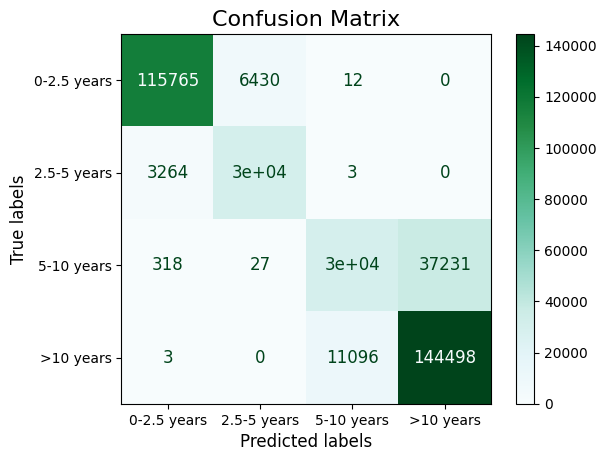

In [37]:
# predictions on train set
y_pred_train = tree.predict(train_X)

# Define your desired order of labels
desired_order = ['0-2.5 years', '2.5-5 years', '5-10 years', '>10 years']

# Sort the labels based on the desired order
sorted_labels = sorted(tree.classes_, key=lambda x: desired_order.index(x))

# Confusion matrix
cm = confusion_matrix(train_y, y_pred_train, labels=sorted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted_labels)

# Plot confusion matrix
fig, ax = plt.subplots()
#plt.rcParams.update({'font.size': 5})
disp.plot(cmap='BuGn', ax=ax)
for texts in disp.text_:
    for text in texts:
        text.set_fontsize(12)  # Set the font size here

# Increase font size for labels and title
ax.set_xlabel('Predicted labels', fontsize=12)  # Set font size for x-axis label
ax.set_ylabel('True labels', fontsize=12)       # Set font size for y-axis label
ax.set_title('Confusion Matrix', fontsize=16)   # Set font size for the title

# Increase font size for the tick labels
plt.xticks(fontsize=10)  # Set font size for x-axis tick labels
plt.yticks(fontsize=10)  # Set font size for y-axis tick labels
plt.savefig('dt_train_cm.svg')


In [38]:
print("Classification Report - \n",
      classification_report(train_y, y_pred_train))

Classification Report - 
               precision    recall  f1-score   support

 0-2.5 years       0.97      0.95      0.96    122207
 2.5-5 years       0.82      0.90      0.86     33520
  5-10 years       0.73      0.44      0.55     67480
   >10 years       0.80      0.93      0.86    155597

    accuracy                           0.85    378804
   macro avg       0.83      0.81      0.81    378804
weighted avg       0.84      0.85      0.84    378804



In [30]:
# Generating Classification Report
report = classification_report(train_y, y_pred_train, output_dict = True)
report_df = pd.DataFrame(report)
report_df.to_csv('df_train_class_report.csv') 

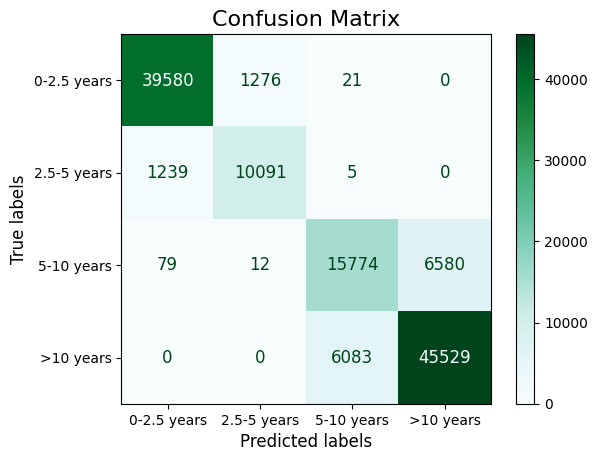

In [31]:
# Predictions on test set
y_pred = tree.predict(test_X)

cm = confusion_matrix(test_y, y_pred, labels = sorted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = sorted_labels)

fig, ax = plt.subplots()
disp.plot(cmap = 'BuGn', ax = ax, values_format='d')

for texts in disp.text_:
    for text in texts:
        text.set_fontsize(12)  # Set the font size here
        
# Increase font size for labels and title
ax.set_xlabel('Predicted labels', fontsize=12)  # Set font size for x-axis label
ax.set_ylabel('True labels', fontsize=12)       # Set font size for y-axis label
ax.set_title('Confusion Matrix', fontsize=16)   # Set font size for the title

# Increase font size for the tick labels
plt.xticks(fontsize=10)  # Set font size for x-axis tick labels
plt.yticks(fontsize=10)  # Set font size for y-axis tick labels
plt.savefig('dt_test_cm.svg')

In [32]:
print("Classification Report - \n",
      classification_report(test_y, y_pred))

Classification Report - 
               precision    recall  f1-score   support

 0-2.5 years       0.97      0.97      0.97     40877
 2.5-5 years       0.89      0.89      0.89     11335
  5-10 years       0.72      0.70      0.71     22445
   >10 years       0.87      0.88      0.88     51612

    accuracy                           0.88    126269
   macro avg       0.86      0.86      0.86    126269
weighted avg       0.88      0.88      0.88    126269



In [19]:
# Generating Classification Report
report = classification_report(test_y, y_pred, output_dict = True)
report_df = pd.DataFrame(report)
report_df.to_csv('df_test_class_report.csv')

In [20]:
importance = tree.feature_importances_

feature_imp = pd.DataFrame(list(zip(train_X.columns, importance)),
               columns = ['Feature', 'Importance'])

feature_imp = feature_imp.sort_values('Importance', ascending = False).reset_index(drop = True)

feature_imp

,Feature,Importance
0,COUNTRY_OF_CITIZENSHIP_INDIA,0.488110
1,COUNTRY_OF_CITIZENSHIP_CHINA,0.156355
2,EMPLOYER_NUM_EMPLOYEES,0.090952
3,PW_AMOUNT_9089,0.087378
4,FW_INFO_YR_REL_EDU_COMPLETED,0.032993
...,...,...
351,COUNTRY_OF_CITIZENSHIP_LUXEMBOURG,0.000000
352,COUNTRY_OF_CITIZENSHIP_MACAU,0.000000
353,COUNTRY_OF_CITIZENSHIP_MACEDONIA,0.000000
354,COUNTRY_OF_CITIZENSHIP_MADAGASCAR,0.000000


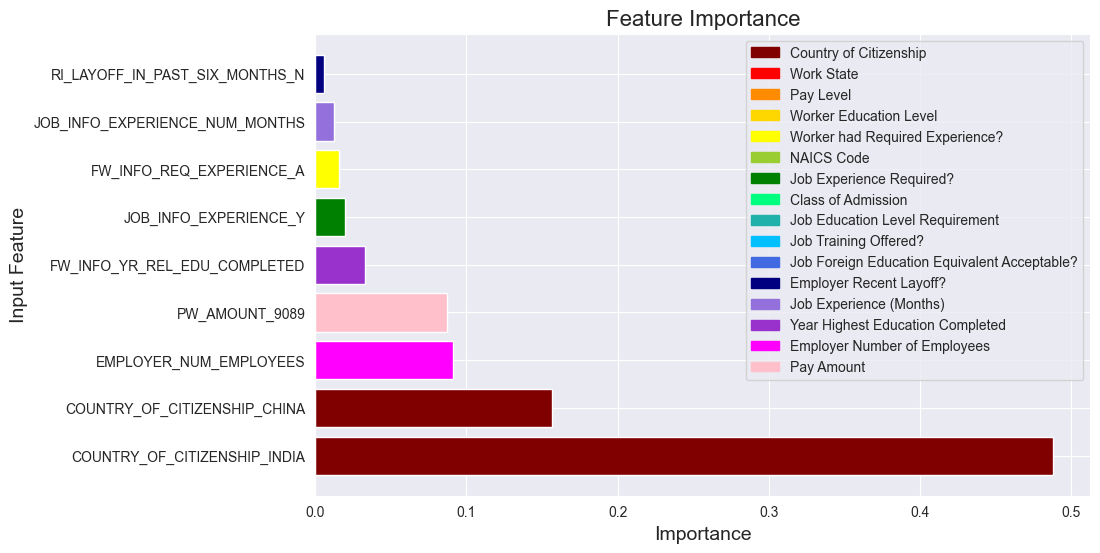

In [21]:

# Define categories and their respective feature lists
categories = {
    'COUNTRY_OF_CITIZENSHIP': [],
    'STATE': [],
    'PW_LEVEL': [],
    'FOREIGN_WORKER_INFO_EDUCATION': [],
    'FW_INFO_REQ_EXPERIENCE': [],
    'NAICS': [],
    'CLASS_OF': [],
    'JOB_INFO_EDUCATION': [],
    'JOB_INFO_TRAINING': [],
    'JOB_INFO_FOREIGN_ED': [],
    'RI_LAYOFF': [],
    'JOB_INFO_EXPERIENCE_NUM_MONTHS': [],
    'FW_INFO_YR_REL_EDU_COMPLETED': [],
    'EMPLOYER_NUM_EMPLOYEES': [],
    'JOB_INFO_EXPERIENCE': [],
    'PW_AMOUNT_9089': []
}

# Iterate over categories to populate the feature lists
for category in categories.keys():
    categories[category] = feature_imp[feature_imp['Feature'].str.contains(category)]['Feature'].tolist()

# Create a color map for categories
color_map = {
    'COUNTRY_OF_CITIZENSHIP': 'maroon',
    'STATE': 'red',
    'PW_LEVEL': 'darkorange',
    'FOREIGN_WORKER_INFO_EDUCATION': 'gold',
    'FW_INFO_REQ_EXPERIENCE': 'yellow',
    'NAICS': 'yellowgreen',
    'JOB_INFO_EXPERIENCE': 'green',
    'CLASS_OF': 'springgreen',
    'JOB_INFO_EDUCATION': 'lightseagreen',
    'JOB_INFO_TRAINING': 'deepskyblue',
    'JOB_INFO_FOREIGN_ED': 'royalblue',
    'RI_LAYOFF': 'navy',
    'JOB_INFO_EXPERIENCE_NUM_MONTHS': 'mediumpurple',
    'FW_INFO_YR_REL_EDU_COMPLETED': 'darkorchid',
    'EMPLOYER_NUM_EMPLOYEES': 'magenta',
    'PW_AMOUNT_9089': 'pink'
}

# Color each feature based on its category
colors = []
for feature in feature_imp['Feature']:
    for category, feature_list in categories.items():
        if feature in feature_list:
            colors.append(color_map[category])
            break
    else:
        colors.append('gray')  # default color for features not belonging to any category

# Selecting features with specific threshold for importance values
feature_imp_nonzero = feature_imp[feature_imp['Importance'] > 0.005]

display_names = {
    'COUNTRY_OF_CITIZENSHIP': 'Country of Citizenship',
    'STATE': 'Work State',
    'PW_LEVEL': 'Pay Level',
    'FOREIGN_WORKER_INFO_EDUCATION': 'Worker Education Level',
    'FW_INFO_REQ_EXPERIENCE': 'Worker had Required Experience?',
    'NAICS': 'NAICS Code',
    'JOB_INFO_EXPERIENCE': 'Job Experience Required?',
    'CLASS_OF': 'Class of Admission',
    'JOB_INFO_EDUCATION': 'Job Education Level Requirement',
    'JOB_INFO_TRAINING': 'Job Training Offered?',
    'JOB_INFO_FOREIGN_ED': 'Job Foreign Education Equivalent Acceptable?',
    'RI_LAYOFF': 'Employer Recent Layoff?',
    'JOB_INFO_EXPERIENCE_NUM_MONTHS': 'Job Experience (Months)',
    'FW_INFO_YR_REL_EDU_COMPLETED': 'Year Highest Education Completed',
    'EMPLOYER_NUM_EMPLOYEES': 'Employer Number of Employees',
    'PW_AMOUNT_9089': 'Pay Amount'
}

# Bar plot with colored bars
plt.figure(figsize=(10, 6), dpi=100)
bars = plt.barh(feature_imp_nonzero['Feature'], feature_imp_nonzero['Importance'], color=colors)

# Additional plot configurations
plt.xlabel("Importance", fontsize=14)
plt.ylabel("Input Feature", fontsize=14)
plt.title("Feature Importance", fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add legend for categories
legend_handles = [plt.Rectangle((0,0),1,1, color=color) for color in color_map.values()]
plt.legend(legend_handles, [display_names.get(category, category) for category in color_map.keys()], loc='upper right')

plt.savefig('dt_importance_ind.svg')

plt.show()


In [22]:
# Aggregate Feature Importances
country_features = feature_imp[feature_imp['Feature'].str.contains('COUNTRY_OF_CITIZENSHIP')]
country_importance = country_features['Importance'].sum()

work_state_features = feature_imp[feature_imp['Feature'].str.contains('STATE')]
work_state_importance = work_state_features['Importance'].sum()

pay_features = feature_imp[feature_imp['Feature'].str.contains('PW_LEVEL')]
pay_importance = pay_features['Importance'].sum()

edu_features = feature_imp[feature_imp['Feature'].str.contains('FOREIGN_WORKER_INFO_EDUCATION')]
edu_importance = edu_features['Importance'].sum()

fw_req_exp_features = feature_imp[feature_imp['Feature'].str.contains('FW_INFO_REQ_EXPERIENCE')]
fw_req_exp_importance = fw_req_exp_features['Importance'].sum()

naics_features = feature_imp[feature_imp['Feature'].str.contains('NAICS')]
naics_importance = naics_features['Importance'].sum()

job_exp_features = feature_imp[feature_imp['Feature'].str.contains('JOB_INFO_EXPERIENCE')]
job_exp_importance = job_exp_features['Importance'].sum()

class_features = feature_imp[feature_imp['Feature'].str.contains('CLASS_OF')]
class_importance = class_features['Importance'].sum()

job_edu_features = feature_imp[feature_imp['Feature'].str.contains('JOB_INFO_EDUCATION')]
job_edu_importance = job_edu_features['Importance'].sum()

job_train_features = feature_imp[feature_imp['Feature'].str.contains('JOB_INFO_TRAINING')]
job_train_importance = job_train_features['Importance'].sum()

job_foreign_edu_features = feature_imp[feature_imp['Feature'].str.contains('JOB_INFO_FOREIGN_ED')]
job_foreign_edu_importance = job_foreign_edu_features['Importance'].sum()

layoff_features = feature_imp[feature_imp['Feature'].str.contains('RI_LAYOFF')]
layoff_importance = layoff_features['Importance'].sum()

In [23]:
# Extracting the importance values directly from the DataFrame
employer_num_employees_importance = feature_imp[feature_imp['Feature'] == 'EMPLOYER_NUM_EMPLOYEES']['Importance'].sum()
fw_info_yr_rel_edu_completed_importance = feature_imp[feature_imp['Feature'] == 'FW_INFO_YR_REL_EDU_COMPLETED']['Importance'].sum()
job_info_experience_num_months_importance = feature_imp[feature_imp['Feature'] == 'JOB_INFO_EXPERIENCE_NUM_MONTHS']['Importance'].sum()

# Create a dictionary with feature names as keys and their summed importance as values
data = {
    'Country of Citizenship': country_importance,
    'Work State': work_state_importance,
    'Pay Level': pay_importance,
    'Worker Education Level': edu_importance,
    'Worker has Required Experience?': fw_req_exp_importance,
    'NAICS Code': naics_importance,
    'Job Experience Required?': job_exp_importance,
    'Class of Admission': class_importance,
    'Job Education Level Requirement': job_edu_importance,
    'Job Training Offered?': job_train_importance,
    'Job Foreign Education Equivalent Acceptable?': job_foreign_edu_importance,
    'Employer Recent Layoff?': layoff_importance,
    'Employer Number of Employees': employer_num_employees_importance,
    'Year Highest Education Completed': fw_info_yr_rel_edu_completed_importance,
    'Job Experience (Months)': job_info_experience_num_months_importance
}

# Convert dictionary to DataFrame
feature_importances = pd.DataFrame(list(data.items()), columns=['Feature', 'Importance'])

feature_importances

,Feature,Importance
0,Country of Citizenship,0.645262
1,Work State,0.036077
2,Pay Level,0.009162
3,Worker Education Level,0.005000
4,Worker has Required Experience?,0.022692
5,NAICS Code,0.021082
6,Job Experience Required?,0.033551
7,Class of Admission,0.004350
8,Job Education Level Requirement,0.004357
9,Job Training Offered?,0.000139


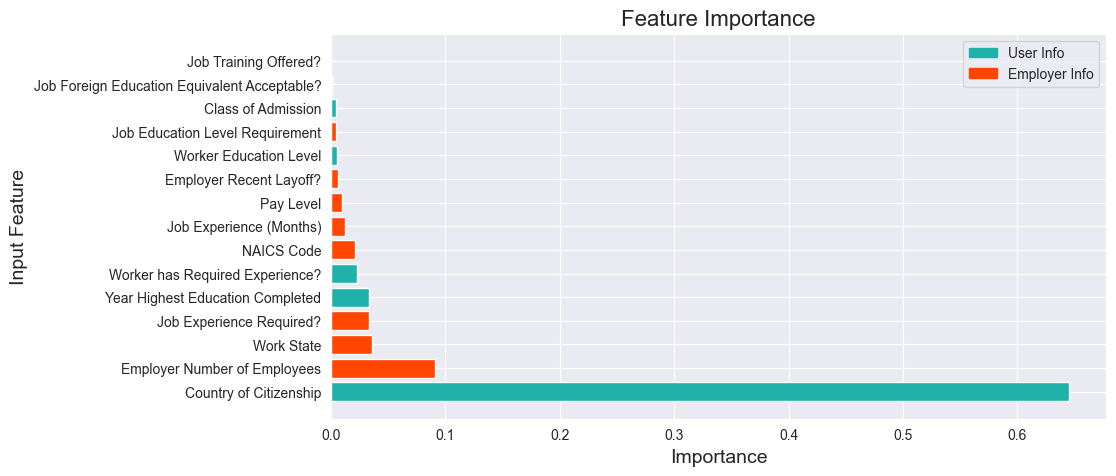

In [24]:
# Define categories and their corresponding colors
category_colors = {
    'User Info': 'lightseagreen',
    'Employer Info': 'orangered'
}

# Create a function to categorize features
def categorize_feature(feature_name):
    user_info_features = ['Country of Citizenship', 'Worker Education Level', 'Worker has Required Experience?', 'Class of Admission', 'Year Highest Education Completed']
    if feature_name in user_info_features:
        return 'User Info'
    else:
        return 'Employer Info'

# Apply the function to categorize each feature and create a new column in feature_importances DataFrame
feature_importances['Category'] = feature_importances['Feature'].apply(categorize_feature)

# Sort features by importance in ascending order
feature_importances_sorted = feature_importances.sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 5), dpi=100)
for index, row in feature_importances_sorted.iterrows():
    plt.barh(row['Feature'], row['Importance'], color=category_colors[row['Category']])

plt.xlabel("Importance", fontsize=14)
plt.ylabel("Input Feature", fontsize=14)
plt.title("Feature Importance", fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Create legend
handles = [plt.Rectangle((0,0),1,1, color=color) for color in category_colors.values()]
plt.legend(handles, category_colors.keys(), loc='upper right')

plt.savefig('dt_importance.svg')



In [25]:
f1_dt = f1_score(test_y, y_pred, average='macro')
f1_weighted_dt = f1_score(test_y, y_pred, average='weighted')
accuracy_dt = accuracy_score(test_y, y_pred)

SHAP SHAP SHAP SHAP SHAP SHAP SHAP SHAP SHAP SHAP

In [ ]:
# Compute shap values
explainer = shap.TreeExplainer(bestClassTree)
shap_values = explainer.shap_values(test_X)

In [ ]:
shap_dt_pickle = open('decision_tree_shap.pickle', 'wb')

pickle.dump(explainer, shap_dt_pickle) 

# Close the file
shap_dt_pickle.close() 

In [ ]:
shap_values_dt_pickle = open('decision_tree_shap_values.pickle', 'wb')

pickle.dump(shap_values, shap_values_dt_pickle) 

# Close the file
shap_values_dt_pickle.close() 

In [ ]:
shap_dt_pickle = open('decision_tree_shap.pickle', 'rb')
explainer = pickle.load(shap_dt_pickle)
shap_dt_pickle.close()

In [ ]:
shap_values_dt_pickle = open('decision_tree_shap_values.pickle', 'rb')
shap_values = pickle.load(shap_values_dt_pickle)
shap_values_dt_pickle.close()

In [ ]:
shap_values.shape

In [ ]:
print("Shape of shap_values matrix:", shap_values.shape)
print("Shape of test_X matrix:", test_X.shape)

In [ ]:
shap_values_summary = np.mean(shap_values, axis=2)  # or np.sum(shap_values, axis=2)

# Now shap_values_summary will have shape (101151, 355), which can be used for summary plots
print("Shape of summarized SHAP values:", shap_values_summary.shape)

num_classes = shap_values.shape[2]

In [ ]:
class_index = 3
data_index = 1

# Create Explanation object for the specified class and data point
expl = shap.Explanation(values=shap_values[data_index,:,class_index],
                        base_values=shap.TreeExplainer(bestClassTree).expected_value[class_index],
                        data=test_X.iloc[data_index],
                        feature_names=test_X.columns)

# Generate waterfall plot
shap.plots.waterfall(expl)


In [ ]:
# Calculate mean absolute SHAP values for Reject and Accept classes
mean_abs_shap_class1 = np.mean(np.abs(shap_values[:, :, 0]), axis=0)
mean_abs_shap_class2 = np.mean(np.abs(shap_values[:, :, 1]), axis=0)
mean_abs_shap_class3 = np.mean(np.abs(shap_values[:, :, 2]), axis=0)
mean_abs_shap_class4 = np.mean(np.abs(shap_values[:, :, 3]), axis=0)

# Create a DataFrame for easier manipulation and visualization
df_shap = pd.DataFrame({
    'Feature': test_X.columns,
    'MeanAbsShapClass1': mean_abs_shap_class1,
    'MeanAbsShapClass2': mean_abs_shap_class2,
    'MeanAbsShapClass3': mean_abs_shap_class3,
    'MeanAbsShapClass4': mean_abs_shap_class4
})

# Add a total for sorting purposes
df_shap['TotalMeanAbsShap'] = df_shap['MeanAbsShapClass1'] + df_shap['MeanAbsShapClass2'] + df_shap['MeanAbsShapClass3'] + df_shap['MeanAbsShapClass4']

# Sort the DataFrame by total mean absolute SHAP values in descending order
df_shap.sort_values(by='TotalMeanAbsShap', ascending=False, inplace=True)

df_shap

In [ ]:
df_filtered = df_shap[(df_shap['MeanAbsShapClass1'] > 0.001) | (df_shap['MeanAbsShapClass2'] > 0.001) | (df_shap['MeanAbsShapClass3'] > 0.001) | (df_shap['MeanAbsShapClass4'] > 0.001)]

# Set up the plot
plt.figure(figsize=(10, 8))
y = np.arange(len(df_filtered))  # the label locations

plt.barh(y, df_filtered['MeanAbsShapClass1'], color='red', label='0-2.5 years')
plt.barh(y, df_filtered['MeanAbsShapClass2'], left=df_filtered['MeanAbsShapClass1'], color='blue', label='2.5-5 years')
plt.barh(y, df_filtered['MeanAbsShapClass3'], left=df_filtered['MeanAbsShapClass1'] + df_filtered['MeanAbsShapClass2'], color='green', label='5-10 years')
plt.barh(y, df_filtered['MeanAbsShapClass4'], left=df_filtered['MeanAbsShapClass1'] + df_filtered['MeanAbsShapClass2'] + df_filtered['MeanAbsShapClass3'], color='purple', label='>10 years')


plt.xlabel('Mean Absolute SHAP Value')
plt.title('Mean Absolute SHAP Values by Feature for All Classes')
plt.yticks(y, df_filtered['Feature'])
plt.legend()
plt.tight_layout()  # Fit everything nicely into the figure
plt.show()

In [ ]:
# Calculate average SHAP values for Reject and Accept classes
avg_shap_class1 = np.mean(shap_values[:, :, 0], axis=0)
avg_shap_class2 = np.mean(shap_values[:, :, 1], axis=0)
avg_shap_class3 = np.mean(shap_values[:, :, 2], axis=0)
avg_shap_class4 = np.mean(shap_values[:, :, 3], axis=0)

# Create a DataFrame for easier manipulation and visualization
df_shap = pd.DataFrame({
    'Feature': test_X.columns,
    'AvgShapClass1': avg_shap_class1,
    'AvgShapClass2': avg_shap_class2,
    'AvgShapClass3': avg_shap_class3,
    'AvgShapClass4': avg_shap_class4
})

# Sort the DataFrame by the absolute sum of average SHAP values for visibility
df_shap['SortKey'] = (np.abs(df_shap['AvgShapClass1']) + 
                      np.abs(df_shap['AvgShapClass2']) +
                      np.abs(df_shap['AvgShapClass3']) +
                      np.abs(df_shap['AvgShapClass4']))
df_shap.sort_values('SortKey', ascending=False, inplace=True)
df_shap.drop('SortKey', axis=1, inplace=True)

df_shap

In [ ]:
df_filtered = df_shap[(df_shap['AvgShapClass1'] > 0.001) | 
                      (df_shap['AvgShapClass2'] > 0.001) |
                      (df_shap['AvgShapClass3'] > 0.001) |
                      (df_shap['AvgShapClass4'] > 0.001)]

# Set up the plots with four subplots arranged vertically
fig, axes = plt.subplots(4, 1, figsize=(10, 16))  # Adjust the figsize if needed

# Horizontal bar plot for each class
axes[0].barh(df_filtered['Feature'], df_filtered['AvgShapClass1'], color='red', label='0-2.5 years')
axes[0].set_title('Average SHAP Values for 0-2.5 years')
axes[0].set_xlabel('Average SHAP Value')
axes[0].set_ylabel('Features')
axes[0].legend()

axes[1].barh(df_filtered['Feature'], df_filtered['AvgShapClass2'], color='blue', label='2.5-5 years')
axes[1].set_title('Average SHAP Values for 2.5-5 years')
axes[1].set_xlabel('Average SHAP Value')
axes[1].set_ylabel('Features')
axes[1].legend()

axes[2].barh(df_filtered['Feature'], df_filtered['AvgShapClass3'], color='green', label='5-10 years')
axes[2].set_title('Average SHAP Values for 5-10 years')
axes[2].set_xlabel('Average SHAP Value')
axes[2].set_ylabel('Features')
axes[2].legend()

axes[3].barh(df_filtered['Feature'], df_filtered['AvgShapClass4'], color='purple', label='>10 years')
axes[3].set_title('Average SHAP Values for >10 years')
axes[3].set_xlabel('Average SHAP Value')
axes[3].set_ylabel('Features')
axes[3].legend()

# Adjust layout to prevent overlap and ensure all labels, titles, and legends are visible
plt.tight_layout()
plt.show()

In [ ]:
def aggregate_shap_by_category(df_shap, category_keywords):
    aggregated_shap = {}
    for category, keywords in category_keywords.items():
        # Filter features based on keywords and sum their SHAP values
        category_features = df_shap[df_shap['Feature'].str.contains('|'.join(keywords))]
        # Sum the SHAP values for each class
        aggregated_shap[category] = {
            'AvgShapClass1': category_features['AvgShapClass1'].sum(),
            'AvgShapClass2': category_features['AvgShapClass2'].sum(),
            'AvgShapClass3': category_features['AvgShapClass3'].sum(),
            'AvgShapClass4': category_features['AvgShapClass4'].sum()
        }
    return pd.DataFrame.from_dict(aggregated_shap, orient='index')

# Define the keywords for each category
category_keywords = {
    'Country of Citizenship': ['COUNTRY_OF_CITIZENSHIP'],
    'Work State': ['STATE'],
    'Pay Level': ['PW_LEVEL'],
    'Worker Education Level': ['FOREIGN_WORKER_INFO_EDUCATION'],
    'Worker has Required Experience?': ['FW_INFO_REQ_EXPERIENCE'],
    'NAICS Code': ['NAICS'],
    'Job Experience Required?': ['JOB_INFO_EXPERIENCE'],
    'Class of Admission': ['CLASS_OF'],
    'Job Education Level Requirement': ['JOB_INFO_EDUCATION'],
    'Job Training Offered?': ['JOB_INFO_TRAINING'],
    'Job Foreign Education Equivalent Acceptable?': ['JOB_INFO_FOREIGN_ED'],
    'Employer Recent Layoff': ['RI_LAYOFF'],
    'Employer Number of Employees': ['EMPLOYER_NUM_EMPLOYEES'],
    'Year Highest Education Completed': ['FW_INFO_YR_REL_EDU_COMPLETED'],
    'Job Experience (Months)': ['JOB_INFO_EXPERIENCE_NUM_MONTHS']
}

# Aggregate SHAP values by the defined categories
aggregated_shap_values = aggregate_shap_by_category(df_shap, category_keywords)

# Plot the aggregated SHAP values for each class
fig, axes = plt.subplots(4, 1, figsize=(10, 16))
classes = ['AvgShapClass1', 'AvgShapClass2', 'AvgShapClass3', 'AvgShapClass4']
colors = ['red', 'blue', 'green', 'purple']
titles = ['0-2.5 years', '2.5-5 years', '5-10 years', '>10 years']

for i, (ax, cls, color, title) in enumerate(zip(axes, classes, colors, titles)):
    ax.barh(aggregated_shap_values.index, aggregated_shap_values[cls], color=color, label=title)
    ax.set_title(f'Average SHAP Values for {title}')
    ax.set_xlabel('Aggregated SHAP Value')
    ax.set_ylabel('Feature Category')
    ax.legend()

plt.tight_layout()
plt.show()

RANDOM FOREST RANDOM FOREST RANDOM FOREST RANDOM FOREST RANDOM FOREST RANDOM FOREST RANDOM FOREST RANDOM FOREST RANDOM FOREST RANDOM FOREST RANDOM FOREST RANDOM FOREST RANDOM FOREST RANDOM FOREST RANDOM FOREST RANDOM FOREST RANDOM FOREST RANDOM FOREST RANDOM FOREST RANDOM FOREST RANDOM FOREST RANDOM FOREST RANDOM FOREST RANDOM FOREST RANDOM FOREST

In [22]:
# Best Forest
mtry_fraction = 0.5  # Mtry as a fraction of the total number of predictors (0.005 seems to be best)

# Calculate the actual Mtry value based on the fraction
num_predictors = len(train_X.columns)
mtry = int(np.ceil(mtry_fraction * num_predictors))

bestClassForest = RandomForestClassifier(max_depth=105, min_samples_leaf=2, min_samples_split=2,
                      random_state=9)

In [23]:
start = time.time()            # Start Time
forest = bestClassForest.fit(train_X, train_y)
stop = time.time()             # End Time
print(f"Training time: {stop - start}s")

Training time: 56.95590400695801s


In [24]:
# Creating the file where we want to write the model
rf_pickle = open('random_forest_immigration.pickle', 'wb')

# Write DT model to the file
pickle.dump(forest, rf_pickle)

# Close the file
rf_pickle.close() 

In [25]:
rf_pickle = open('random_forest_immigration.pickle', 'rb')
forest = pickle.load(rf_pickle)
rf_pickle.close()

In [26]:
# predictions on train set
y_pred_train = forest.predict(train_X)

# Sort the labels based on the desired order
forest_sorted_labels = sorted(forest.classes_, key=lambda x: desired_order.index(x))

# confusion matrix
cm = confusion_matrix(train_y, y_pred_train, labels = forest_sorted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = forest_sorted_labels)

fig, ax = plt.subplots()
disp.plot(cmap = 'RdPu', ax = ax, values_format='d')
for texts in disp.text_:
    for text in texts:
        text.set_fontsize(12)  # Set the font size here

# Increase font size for labels and title
ax.set_xlabel('Predicted labels', fontsize=12)  # Set font size for x-axis label
ax.set_ylabel('True labels', fontsize=12)       # Set font size for y-axis label
ax.set_title('Confusion Matrix', fontsize=16)   # Set font size for the title

# Increase font size for the tick labels
plt.xticks(fontsize=10)  # Set font size for x-axis tick labels
plt.yticks(fontsize=10)  # Set font size for y-axis tick labels
plt.savefig('rf_train_cm.svg')

NameError: name 'desired_order' is not defined

In [27]:
print("Classification Report - \n",
      classification_report(train_y, y_pred_train))

Classification Report - 
               precision    recall  f1-score   support

 0-2.5 years       0.99      0.95      0.97    122207
 2.5-5 years       0.84      0.99      0.91     33520
  5-10 years       0.87      0.50      0.64     67480
   >10 years       0.82      0.97      0.89    155597

    accuracy                           0.88    378804
   macro avg       0.88      0.85      0.85    378804
weighted avg       0.89      0.88      0.87    378804



In [37]:
# Generating Classification Report
report = classification_report(train_y, y_pred_train, output_dict = True)
report_df = pd.DataFrame(report)
report_df.to_csv('rf_train_class_report.csv')

In [28]:
# Predictions on test set
y_pred = forest.predict(test_X)

cm = confusion_matrix(test_y, y_pred, labels = forest_sorted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = forest_sorted_labels)

fig, ax = plt.subplots()
disp.plot(cmap = 'RdPu', ax = ax, values_format='d')
for texts in disp.text_:
    for text in texts:
        text.set_fontsize(12)  # Set the font size here

# Increase font size for labels and title
ax.set_xlabel('Predicted labels', fontsize=12)  # Set font size for x-axis label
ax.set_ylabel('True labels', fontsize=12)       # Set font size for y-axis label
ax.set_title('Confusion Matrix', fontsize=16)   # Set font size for the title

# Increase font size for the tick labels
plt.xticks(fontsize=10)  # Set font size for x-axis tick labels
plt.yticks(fontsize=10)  # Set font size for y-axis tick labels
plt.savefig('rf_test_cm.svg')

NameError: name 'forest_sorted_labels' is not defined

In [29]:
print("Classification Report - \n",
      classification_report(test_y, y_pred))

Classification Report - 
               precision    recall  f1-score   support

 0-2.5 years       0.99      0.93      0.96     40877
 2.5-5 years       0.81      0.97      0.88     11335
  5-10 years       0.81      0.44      0.57     22445
   >10 years       0.80      0.96      0.87     51612

    accuracy                           0.86    126269
   macro avg       0.85      0.83      0.82    126269
weighted avg       0.86      0.86      0.85    126269



In [62]:
# Generating Classification Report
report = classification_report(test_y, y_pred, output_dict = True)
report_df = pd.DataFrame(report)
report_df.to_csv('rf_test_class_report.csv')

In [63]:
importance = forest.feature_importances_

feature_imp = pd.DataFrame(list(zip(train_X.columns, importance)),
               columns = ['Feature', 'Importance'])

feature_imp = feature_imp.sort_values('Importance', ascending = False).reset_index(drop = True)

feature_imp

,Feature,Importance
0,COUNTRY_OF_CITIZENSHIP_INDIA,0.344284
1,COUNTRY_OF_CITIZENSHIP_CHINA,0.128011
2,PW_AMOUNT_9089,0.063681
3,EMPLOYER_NUM_EMPLOYEES,0.056413
4,FW_INFO_YR_REL_EDU_COMPLETED,0.045996
...,...,...
351,COUNTRY_OF_CITIZENSHIP_MARSHALL ISLANDS,0.000000
352,CLASS_OF_ADMISSION_K-4,0.000000
353,COUNTRY_OF_CITIZENSHIP_MICRONESIA,0.000000
354,COUNTRY_OF_CITIZENSHIP_BURUNDI,0.000000


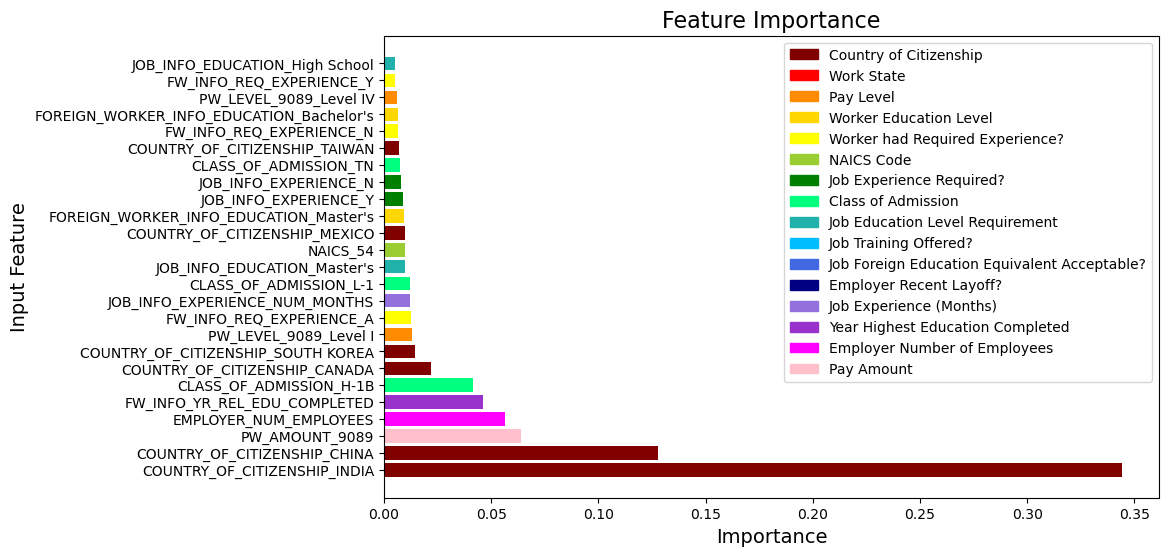

In [64]:

# Define categories and their respective feature lists
categories = {
    'COUNTRY_OF_CITIZENSHIP': [],
    'STATE': [],
    'PW_LEVEL': [],
    'FOREIGN_WORKER_INFO_EDUCATION': [],
    'FW_INFO_REQ_EXPERIENCE': [],
    'NAICS': [],
    'CLASS_OF': [],
    'JOB_INFO_EDUCATION': [],
    'JOB_INFO_TRAINING': [],
    'JOB_INFO_FOREIGN_ED': [],
    'RI_LAYOFF': [],
    'JOB_INFO_EXPERIENCE_NUM_MONTHS': [],
    'FW_INFO_YR_REL_EDU_COMPLETED': [],
    'EMPLOYER_NUM_EMPLOYEES': [],
    'JOB_INFO_EXPERIENCE': [],
    'PW_AMOUNT_9089': []
}

# Iterate over categories to populate the feature lists
for category in categories.keys():
    categories[category] = feature_imp[feature_imp['Feature'].str.contains(category)]['Feature'].tolist()

# Create a color map for categories
color_map = {
    'COUNTRY_OF_CITIZENSHIP': 'maroon',
    'STATE': 'red',
    'PW_LEVEL': 'darkorange',
    'FOREIGN_WORKER_INFO_EDUCATION': 'gold',
    'FW_INFO_REQ_EXPERIENCE': 'yellow',
    'NAICS': 'yellowgreen',
    'JOB_INFO_EXPERIENCE': 'green',
    'CLASS_OF': 'springgreen',
    'JOB_INFO_EDUCATION': 'lightseagreen',
    'JOB_INFO_TRAINING': 'deepskyblue',
    'JOB_INFO_FOREIGN_ED': 'royalblue',
    'RI_LAYOFF': 'navy',
    'JOB_INFO_EXPERIENCE_NUM_MONTHS': 'mediumpurple',
    'FW_INFO_YR_REL_EDU_COMPLETED': 'darkorchid',
    'EMPLOYER_NUM_EMPLOYEES': 'magenta',
    'PW_AMOUNT_9089': 'pink'
}

# Color each feature based on its category
colors = []
for feature in feature_imp['Feature']:
    for category, feature_list in categories.items():
        if feature in feature_list:
            colors.append(color_map[category])
            break
    else:
        colors.append('gray')  # default color for features not belonging to any category

# Selecting features with specific threshold for importance values
feature_imp_nonzero = feature_imp[feature_imp['Importance'] > 0.005]

display_names = {
    'COUNTRY_OF_CITIZENSHIP': 'Country of Citizenship',
    'STATE': 'Work State',
    'PW_LEVEL': 'Pay Level',
    'FOREIGN_WORKER_INFO_EDUCATION': 'Worker Education Level',
    'FW_INFO_REQ_EXPERIENCE': 'Worker had Required Experience?',
    'NAICS': 'NAICS Code',
    'JOB_INFO_EXPERIENCE': 'Job Experience Required?',
    'CLASS_OF': 'Class of Admission',
    'JOB_INFO_EDUCATION': 'Job Education Level Requirement',
    'JOB_INFO_TRAINING': 'Job Training Offered?',
    'JOB_INFO_FOREIGN_ED': 'Job Foreign Education Equivalent Acceptable?',
    'RI_LAYOFF': 'Employer Recent Layoff?',
    'JOB_INFO_EXPERIENCE_NUM_MONTHS': 'Job Experience (Months)',
    'FW_INFO_YR_REL_EDU_COMPLETED': 'Year Highest Education Completed',
    'EMPLOYER_NUM_EMPLOYEES': 'Employer Number of Employees',
    'PW_AMOUNT_9089': 'Pay Amount'
}

# Bar plot with colored bars
plt.figure(figsize=(10, 6), dpi=100)
bars = plt.barh(feature_imp_nonzero['Feature'], feature_imp_nonzero['Importance'], color=colors)

# Additional plot configurations
plt.xlabel("Importance", fontsize=14)
plt.ylabel("Input Feature", fontsize=14)
plt.title("Feature Importance", fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add legend for categories
legend_handles = [plt.Rectangle((0,0),1,1, color=color) for color in color_map.values()]
plt.legend(legend_handles, [display_names.get(category, category) for category in color_map.keys()], loc='upper right')

plt.savefig('rf_importance_ind.svg')

plt.show()


In [65]:
# Aggregate Feature Importances
country_features = feature_imp[feature_imp['Feature'].str.contains('COUNTRY_OF_CITIZENSHIP')]
country_importance = country_features['Importance'].sum()

work_state_features = feature_imp[feature_imp['Feature'].str.contains('STATE')]
work_state_importance = work_state_features['Importance'].sum()

pay_features = feature_imp[feature_imp['Feature'].str.contains('PW_LEVEL')]
pay_importance = pay_features['Importance'].sum()

edu_features = feature_imp[feature_imp['Feature'].str.contains('FOREIGN_WORKER_INFO_EDUCATION')]
edu_importance = edu_features['Importance'].sum()

fw_req_exp_features = feature_imp[feature_imp['Feature'].str.contains('FW_INFO_REQ_EXPERIENCE')]
fw_req_exp_importance = fw_req_exp_features['Importance'].sum()

naics_features = feature_imp[feature_imp['Feature'].str.contains('NAICS')]
naics_importance = naics_features['Importance'].sum()

job_exp_features = feature_imp[feature_imp['Feature'].str.contains('JOB_INFO_EXPERIENCE')]
job_exp_importance = job_exp_features['Importance'].sum()

class_features = feature_imp[feature_imp['Feature'].str.contains('CLASS_OF')]
class_importance = class_features['Importance'].sum()

job_edu_features = feature_imp[feature_imp['Feature'].str.contains('JOB_INFO_EDUCATION')]
job_edu_importance = job_edu_features['Importance'].sum()

job_train_features = feature_imp[feature_imp['Feature'].str.contains('JOB_INFO_TRAINING')]
job_train_importance = job_train_features['Importance'].sum()

job_foreign_edu_features = feature_imp[feature_imp['Feature'].str.contains('JOB_INFO_FOREIGN_ED')]
job_foreign_edu_importance = job_foreign_edu_features['Importance'].sum()

layoff_features = feature_imp[feature_imp['Feature'].str.contains('RI_LAYOFF')]
layoff_importance = layoff_features['Importance'].sum()

In [66]:
# Extracting the importance values directly from the DataFrame
employer_num_employees_importance = feature_imp[feature_imp['Feature'] == 'EMPLOYER_NUM_EMPLOYEES']['Importance'].sum()
fw_info_yr_rel_edu_completed_importance = feature_imp[feature_imp['Feature'] == 'FW_INFO_YR_REL_EDU_COMPLETED']['Importance'].sum()
job_info_experience_num_months_importance = feature_imp[feature_imp['Feature'] == 'JOB_INFO_EXPERIENCE_NUM_MONTHS']['Importance'].sum()

# Create a dictionary with feature names as keys and their summed importance as values
data = {
    'Country of Citizenship': country_importance,
    'Work State': work_state_importance,
    'Pay Level': pay_importance,
    'Worker Education Level': edu_importance,
    'Worker has Required Experience?': fw_req_exp_importance,
    'NAICS Code': naics_importance,
    'Job Experience Required?': job_exp_importance,
    'Class of Admission': class_importance,
    'Job Education Level Requirement': job_edu_importance,
    'Job Training Offered?': job_train_importance,
    'Job Foreign Education Equivalent Acceptable?': job_foreign_edu_importance,
    'Employer Recent Layoff?': layoff_importance,
    'Employer Number of Employees': employer_num_employees_importance,
    'Year Highest Education Completed': fw_info_yr_rel_edu_completed_importance,
    'Job Experience (Months)': job_info_experience_num_months_importance
}

# Convert dictionary to DataFrame
feature_importances = pd.DataFrame(list(data.items()), columns=['Feature', 'Importance'])

feature_importances

,Feature,Importance
0,Country of Citizenship,0.577763
1,Work State,0.029368
2,Pay Level,0.024433
3,Worker Education Level,0.023798
4,Worker has Required Experience?,0.024588
5,NAICS Code,0.026137
6,Job Experience Required?,0.028731
7,Class of Admission,0.070416
8,Job Education Level Requirement,0.021169
9,Job Training Offered?,0.000639


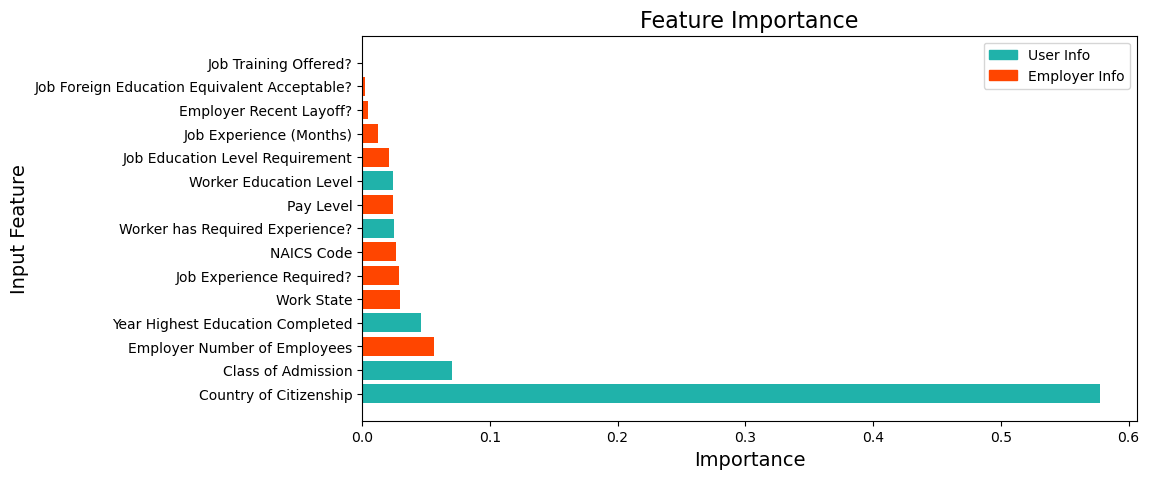

In [67]:
# Define categories and their corresponding colors
category_colors = {
    'User Info': 'lightseagreen',
    'Employer Info': 'orangered'
}

# Create a function to categorize features
def categorize_feature(feature_name):
    user_info_features = ['Country of Citizenship', 'Worker Education Level', 'Worker has Required Experience?', 'Class of Admission', 'Year Highest Education Completed']
    if feature_name in user_info_features:
        return 'User Info'
    else:
        return 'Employer Info'

# Apply the function to categorize each feature and create a new column in feature_importances DataFrame
feature_importances['Category'] = feature_importances['Feature'].apply(categorize_feature)

# Sort features by importance in ascending order
feature_importances_sorted = feature_importances.sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 5), dpi=100)
for index, row in feature_importances_sorted.iterrows():
    plt.barh(row['Feature'], row['Importance'], color=category_colors[row['Category']])

plt.xlabel("Importance", fontsize=14)
plt.ylabel("Input Feature", fontsize=14)
plt.title("Feature Importance", fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Create legend
handles = [plt.Rectangle((0,0),1,1, color=color) for color in category_colors.values()]
plt.legend(handles, category_colors.keys(), loc='upper right')

plt.savefig('rf_importance.svg')


In [115]:
f1_rf = f1_score(test_y, y_pred, average='macro')
f1_weighted_rf = f1_score(test_y, y_pred, average='weighted')
accuracy_rf = accuracy_score(test_y, y_pred)

ADABOOST ADABOOST ADABOOST ADABOOST ADABOOST ADABOOST ADABOOST ADABOOST ADABOOST ADABOOST ADABOOST ADABOOST ADABOOST ADABOOST ADABOOST ADABOOST ADABOOST ADABOOST ADABOOST ADABOOST ADABOOST ADABOOST ADABOOST ADABOOST ADABOOST ADABOOST ADABOOST ADABOOST ADABOOST ADABOOST ADABOOST ADABOOST ADABOOST ADABOOST ADABOOST ADABOOST ADABOOST ADABOOST ADABOOST ADABOOST ADABOOST ADABOOST ADABOOST ADABOOST ADABOOST ADABOOST ADABOOST ADABOOST ADABOOST ADABOOST 

In [69]:
# Best Ada
bestAda = AdaBoostClassifier(estimator =  DecisionTreeClassifier(max_depth=68, min_samples_leaf=2, min_samples_split=13, random_state=9), n_estimators=50, learning_rate=0.01, random_state = 9)

In [70]:
start = time.time()            # Start Time
ada = bestAda.fit(train_X, train_y)
stop = time.time()             # End Time
print(f"Training time: {stop - start}s")

Training time: 689.9590849876404s


In [71]:
# Creating the file where we want to write the model
ada_pickle = open('ada_immigration.pickle', 'wb')

# Write DT model to the file
pickle.dump(ada, ada_pickle) 

# Close the file
ada_pickle.close() 

In [16]:
ada_pickle = open('ada_immigration.pickle', 'rb')
ada = pickle.load(ada_pickle)
ada_pickle.close()

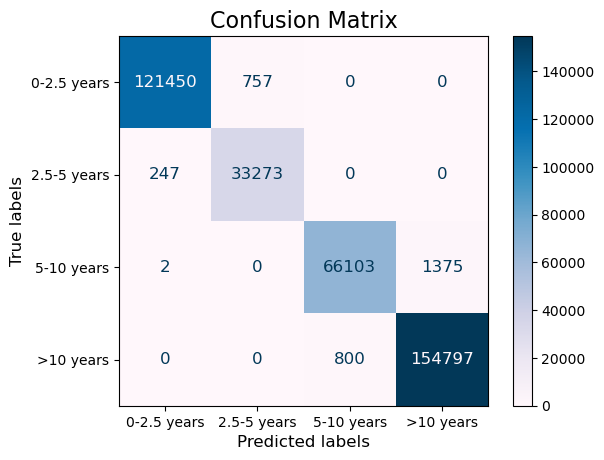

In [19]:
# predictions on train set
y_pred_train = ada.predict(train_X)
# Define your desired order of labels
desired_order = ['0-2.5 years', '2.5-5 years', '5-10 years', '>10 years']
# Sort the labels based on the desired order
ada_sorted_labels = sorted(ada.classes_, key=lambda x: desired_order.index(x))

# confusion matrix
cm = confusion_matrix(train_y, y_pred_train, labels = ada_sorted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ada_sorted_labels)

fig, ax = plt.subplots()
disp.plot(cmap = 'PuBu', ax = ax, values_format='d')
for texts in disp.text_:
    for text in texts:
        text.set_fontsize(12)  # Set the font size here

# Increase font size for labels and title
ax.set_xlabel('Predicted labels', fontsize=12)  # Set font size for x-axis label
ax.set_ylabel('True labels', fontsize=12)       # Set font size for y-axis label
ax.set_title('Confusion Matrix', fontsize=16)   # Set font size for the title

# Increase font size for the tick labels
plt.xticks(fontsize=10)  # Set font size for x-axis tick labels
plt.yticks(fontsize=10)  # Set font size for y-axis tick labels
plt.savefig('ada_train_cm.svg')

In [73]:
print("Classification Report - \n",
      classification_report(train_y, y_pred_train))

Classification Report - 
               precision    recall  f1-score   support

 0-2.5 years       1.00      0.99      1.00    122207
 2.5-5 years       0.98      0.99      0.99     33520
  5-10 years       0.99      0.98      0.98     67480
   >10 years       0.99      0.99      0.99    155597

    accuracy                           0.99    378804
   macro avg       0.99      0.99      0.99    378804
weighted avg       0.99      0.99      0.99    378804



In [74]:
# Generating Classification Report
report = classification_report(train_y, y_pred_train, output_dict = True)
report_df = pd.DataFrame(report)
report_df.to_csv('ada_train_class_report.csv')

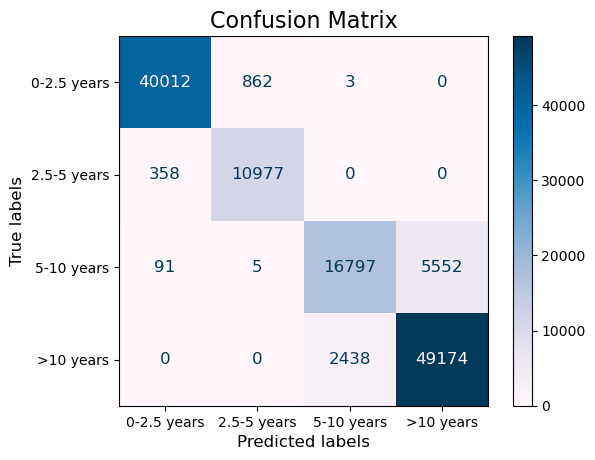

In [20]:
# Predictions on test set
y_pred = ada.predict(test_X)

cm = confusion_matrix(test_y, y_pred, labels = ada_sorted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ada_sorted_labels)

fig, ax = plt.subplots()
disp.plot(cmap = 'PuBu', ax = ax, values_format='d')
for texts in disp.text_:
    for text in texts:
        text.set_fontsize(12)  # Set the font size here

# Increase font size for labels and title
ax.set_xlabel('Predicted labels', fontsize=12)  # Set font size for x-axis label
ax.set_ylabel('True labels', fontsize=12)       # Set font size for y-axis label
ax.set_title('Confusion Matrix', fontsize=16)   # Set font size for the title

# Increase font size for the tick labels
plt.xticks(fontsize=10)  # Set font size for x-axis tick labels
plt.yticks(fontsize=10)  # Set font size for y-axis tick labels
plt.savefig('ada_test_cm.svg')

In [76]:
print("Classification Report - \n",
      classification_report(test_y, y_pred))

Classification Report - 
               precision    recall  f1-score   support

 0-2.5 years       0.99      0.98      0.98     40877
 2.5-5 years       0.93      0.97      0.95     11335
  5-10 years       0.87      0.75      0.81     22445
   >10 years       0.90      0.95      0.92     51612

    accuracy                           0.93    126269
   macro avg       0.92      0.91      0.92    126269
weighted avg       0.93      0.93      0.92    126269



In [77]:
# Generating Classification Report
report = classification_report(test_y, y_pred, output_dict = True)
report_df = pd.DataFrame(report)
report_df.to_csv('ada_test_class_report.csv')

In [21]:
importance = ada.feature_importances_

feature_imp = pd.DataFrame(list(zip(train_X.columns, importance)),
               columns = ['Feature', 'Importance'])

feature_imp = feature_imp.sort_values('Importance', ascending = False).reset_index(drop = True)

feature_imp

,Feature,Importance
0,COUNTRY_OF_CITIZENSHIP_INDIA,0.430204
1,PW_AMOUNT_9089,0.126498
2,EMPLOYER_NUM_EMPLOYEES,0.111244
3,COUNTRY_OF_CITIZENSHIP_CHINA,0.092669
4,FW_INFO_YR_REL_EDU_COMPLETED,0.055986
...,...,...
351,COUNTRY_OF_CITIZENSHIP_MICRONESIA,0.000000
352,COUNTRY_OF_CITIZENSHIP_MOLDOVA,0.000000
353,COUNTRY_OF_CITIZENSHIP_MONACO,0.000000
354,COUNTRY_OF_CITIZENSHIP_MONTENEGRO,0.000000


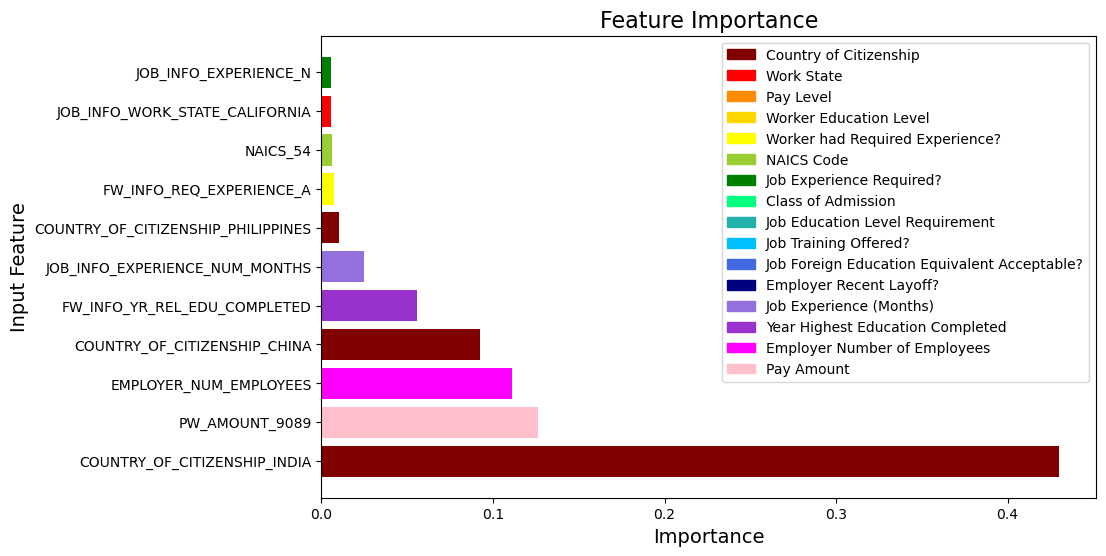

In [27]:

# Define categories and their respective feature lists
categories = {
    'COUNTRY_OF_CITIZENSHIP': [],
    'STATE': [],
    'PW_LEVEL': [],
    'FOREIGN_WORKER_INFO_EDUCATION': [],
    'FW_INFO_REQ_EXPERIENCE': [],
    'NAICS': [],
    'CLASS_OF': [],
    'JOB_INFO_EDUCATION': [],
    'JOB_INFO_TRAINING': [],
    'JOB_INFO_FOREIGN_ED': [],
    'RI_LAYOFF': [],
    'JOB_INFO_EXPERIENCE_NUM_MONTHS': [],
    'FW_INFO_YR_REL_EDU_COMPLETED': [],
    'EMPLOYER_NUM_EMPLOYEES': [],
    'JOB_INFO_EXPERIENCE': [],
    'PW_AMOUNT_9089': []
}

# Iterate over categories to populate the feature lists
for category in categories.keys():
    categories[category] = feature_imp[feature_imp['Feature'].str.contains(category)]['Feature'].tolist()

# Create a color map for categories
color_map = {
    'COUNTRY_OF_CITIZENSHIP': 'maroon',
    'STATE': 'red',
    'PW_LEVEL': 'darkorange',
    'FOREIGN_WORKER_INFO_EDUCATION': 'gold',
    'FW_INFO_REQ_EXPERIENCE': 'yellow',
    'NAICS': 'yellowgreen',
    'JOB_INFO_EXPERIENCE': 'green',
    'CLASS_OF': 'springgreen',
    'JOB_INFO_EDUCATION': 'lightseagreen',
    'JOB_INFO_TRAINING': 'deepskyblue',
    'JOB_INFO_FOREIGN_ED': 'royalblue',
    'RI_LAYOFF': 'navy',
    'JOB_INFO_EXPERIENCE_NUM_MONTHS': 'mediumpurple',
    'FW_INFO_YR_REL_EDU_COMPLETED': 'darkorchid',
    'EMPLOYER_NUM_EMPLOYEES': 'magenta',
    'PW_AMOUNT_9089': 'pink'
}

# Color each feature based on its category
colors = []
for feature in feature_imp['Feature']:
    for category, feature_list in categories.items():
        if feature in feature_list:
            colors.append(color_map[category])
            break
    else:
        colors.append('gray')  # default color for features not belonging to any category

# Selecting features with specific threshold for importance values
feature_imp_nonzero = feature_imp[feature_imp['Importance'] > 0.005]

display_names = {
    'COUNTRY_OF_CITIZENSHIP': 'Country of Citizenship',
    'STATE': 'Work State',
    'PW_LEVEL': 'Pay Level',
    'FOREIGN_WORKER_INFO_EDUCATION': 'Worker Education Level',
    'FW_INFO_REQ_EXPERIENCE': 'Worker had Required Experience?',
    'NAICS': 'NAICS Code',
    'JOB_INFO_EXPERIENCE': 'Job Experience Required?',
    'CLASS_OF': 'Class of Admission',
    'JOB_INFO_EDUCATION': 'Job Education Level Requirement',
    'JOB_INFO_TRAINING': 'Job Training Offered?',
    'JOB_INFO_FOREIGN_ED': 'Job Foreign Education Equivalent Acceptable?',
    'RI_LAYOFF': 'Employer Recent Layoff?',
    'JOB_INFO_EXPERIENCE_NUM_MONTHS': 'Job Experience (Months)',
    'FW_INFO_YR_REL_EDU_COMPLETED': 'Year Highest Education Completed',
    'EMPLOYER_NUM_EMPLOYEES': 'Employer Number of Employees',
    'PW_AMOUNT_9089': 'Pay Amount'
}

# Bar plot with colored bars
plt.figure(figsize=(10, 6), dpi=100)
bars = plt.barh(feature_imp_nonzero['Feature'], feature_imp_nonzero['Importance'], color=colors)

# Additional plot configurations
plt.xlabel("Importance", fontsize=14)
plt.ylabel("Input Feature", fontsize=14)
plt.title("Feature Importance", fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add legend for categories
legend_handles = [plt.Rectangle((0,0),1,1, color=color) for color in color_map.values()]
plt.legend(legend_handles, [display_names.get(category, category) for category in color_map.keys()], loc='upper right')

plt.savefig('ada_importance_ind_poster.svg', bbox_inches='tight', transparent=True, dpi=500)

plt.show()


In [23]:
# Aggregate Feature Importances
country_features = feature_imp[feature_imp['Feature'].str.contains('COUNTRY_OF_CITIZENSHIP')]
country_importance = country_features['Importance'].sum()

work_state_features = feature_imp[feature_imp['Feature'].str.contains('STATE')]
work_state_importance = work_state_features['Importance'].sum()

pay_features = feature_imp[feature_imp['Feature'].str.contains('PW_LEVEL')]
pay_importance = pay_features['Importance'].sum()

edu_features = feature_imp[feature_imp['Feature'].str.contains('FOREIGN_WORKER_INFO_EDUCATION')]
edu_importance = edu_features['Importance'].sum()

fw_req_exp_features = feature_imp[feature_imp['Feature'].str.contains('FW_INFO_REQ_EXPERIENCE')]
fw_req_exp_importance = fw_req_exp_features['Importance'].sum()

naics_features = feature_imp[feature_imp['Feature'].str.contains('NAICS')]
naics_importance = naics_features['Importance'].sum()

job_exp_features = feature_imp[feature_imp['Feature'].str.contains('JOB_INFO_EXPERIENCE')]
job_exp_importance = job_exp_features['Importance'].sum()

class_features = feature_imp[feature_imp['Feature'].str.contains('CLASS_OF')]
class_importance = class_features['Importance'].sum()

job_edu_features = feature_imp[feature_imp['Feature'].str.contains('JOB_INFO_EDUCATION')]
job_edu_importance = job_edu_features['Importance'].sum()

job_train_features = feature_imp[feature_imp['Feature'].str.contains('JOB_INFO_TRAINING')]
job_train_importance = job_train_features['Importance'].sum()

job_foreign_edu_features = feature_imp[feature_imp['Feature'].str.contains('JOB_INFO_FOREIGN_ED')]
job_foreign_edu_importance = job_foreign_edu_features['Importance'].sum()

layoff_features = feature_imp[feature_imp['Feature'].str.contains('RI_LAYOFF')]
layoff_importance = layoff_features['Importance'].sum()

In [24]:
# Extracting the importance values directly from the DataFrame
employer_num_employees_importance = feature_imp[feature_imp['Feature'] == 'EMPLOYER_NUM_EMPLOYEES']['Importance'].sum()
fw_info_yr_rel_edu_completed_importance = feature_imp[feature_imp['Feature'] == 'FW_INFO_YR_REL_EDU_COMPLETED']['Importance'].sum()
job_info_experience_num_months_importance = feature_imp[feature_imp['Feature'] == 'JOB_INFO_EXPERIENCE_NUM_MONTHS']['Importance'].sum()

# Create a dictionary with feature names as keys and their summed importance as values
data = {
    'Country of Citizenship': country_importance,
    'Work State': work_state_importance,
    'Pay Level': pay_importance,
    'Worker Education Level': edu_importance,
    'Worker has Required Experience?': fw_req_exp_importance,
    'NAICS Code': naics_importance,
    'Job Experience Required?': job_exp_importance,
    'Class of Admission': class_importance,
    'Job Education Level Requirement': job_edu_importance,
    'Job Training Offered?': job_train_importance,
    'Job Foreign Education Equivalent Acceptable?': job_foreign_edu_importance,
    'Employer Recent Layoff?': layoff_importance,
    'Employer Number of Employees': employer_num_employees_importance,
    'Year Highest Education Completed': fw_info_yr_rel_edu_completed_importance,
    'Job Experience (Months)': job_info_experience_num_months_importance
}

# Convert dictionary to DataFrame
feature_importances = pd.DataFrame(list(data.items()), columns=['Feature', 'Importance'])

feature_importances

,Feature,Importance
0,Country of Citizenship,0.533664
1,Work State,0.050564
2,Pay Level,0.014120
3,Worker Education Level,0.009906
4,Worker has Required Experience?,0.015811
5,NAICS Code,0.026852
6,Job Experience Required?,0.034931
7,Class of Admission,0.008127
8,Job Education Level Requirement,0.006236
9,Job Training Offered?,0.000274


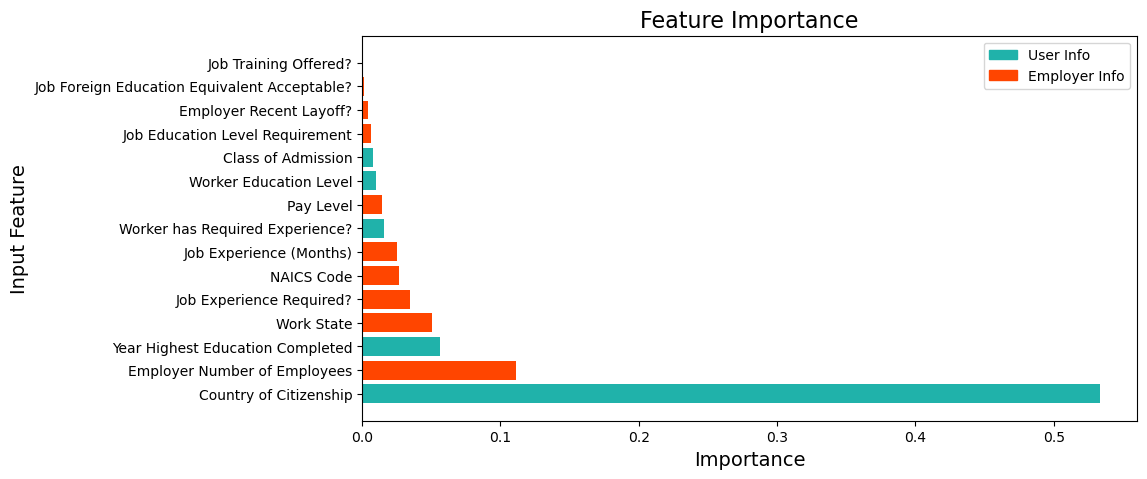

In [26]:
# Define categories and their corresponding colors
category_colors = {
    'User Info': 'lightseagreen',
    'Employer Info': 'orangered'
}

# Create a function to categorize features
def categorize_feature(feature_name):
    user_info_features = ['Country of Citizenship', 'Worker Education Level', 'Worker has Required Experience?', 'Class of Admission', 'Year Highest Education Completed']
    if feature_name in user_info_features:
        return 'User Info'
    else:
        return 'Employer Info'

# Apply the function to categorize each feature and create a new column in feature_importances DataFrame
feature_importances['Category'] = feature_importances['Feature'].apply(categorize_feature)

# Sort features by importance in ascending order
feature_importances_sorted = feature_importances.sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 5), dpi=100)
for index, row in feature_importances_sorted.iterrows():
    plt.barh(row['Feature'], row['Importance'], color=category_colors[row['Category']])

plt.xlabel("Importance", fontsize=14)
plt.ylabel("Input Feature", fontsize=14)
plt.title("Feature Importance", fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Create legend
handles = [plt.Rectangle((0,0),1,1, color=color) for color in category_colors.values()]
plt.legend(handles, category_colors.keys(), loc='upper right')

plt.savefig('ada_importance_poster.svg', bbox_inches='tight',transparent=True, dpi=500)

In [119]:
f1_ada = f1_score(test_y, y_pred, average='macro')
f1_weighted_ada = f1_score(test_y, y_pred, average='weighted')
accuracy_ada = accuracy_score(test_y, y_pred)

XGBoost XGBoost XGBoost XGBoost XGBoost XGBoost XGBoost XGBoost XGBoost XGBoost XGBoost XGBoost XGBoost XGBoost XGBoost XGBoost XGBoost XGBoost XGBoost XGBoost XGBoost XGBoost XGBoost XGBoost XGBoost XGBoost XGBoost XGBoost XGBoost XGBoost XGBoost XGBoost XGBoost XGBoost XGBoost XGBoost XGBoost XGBoost XGBoost XGBoost XGBoost XGBoost XGBoost XGBoost XGBoost XGBoost XGBoost XGBoost XGBoost XGBoost XGBoost XGBoost XGBoost XGBoost XGBoost XGBoost XGBoost XGBoost XGBoost XGBoost XGBoost XGBoost XGBoost XGBoost XGBoost XGBoost XGBoost XGBoost XGBoost XGBoost XGBoost XGBoost XGBoost XGBoost XGBoost XGBoost

In [84]:
from sklearn.preprocessing import LabelEncoder

# Initialize the label encoder
label_encoder = LabelEncoder()

# Encode the target variable
train_y_encoded = label_encoder.fit_transform(train_y)

In [85]:
# Best XGB
bestXGB = XGBClassifier(estimator =  DecisionTreeClassifier(max_depth=68, min_samples_leaf=2, min_samples_split=13, random_state=9), colsample_bytree=0.9, gamma=0, learning_rate=1, n_estimators=220, reg_alpha=1, reg_lambda=10, subsample=1, random_state = 9)

In [86]:
start = time.time()            # Start Time
xg = bestXGB.fit(train_X, train_y_encoded)
stop = time.time()             # End Time
print(f"Training time: {stop - start}s")

[01:53:59] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "estimator" } are not used.

Training time: 369.67187452316284s


In [87]:
# Creating the file where we want to write the model
xgb_pickle = open('xgb_immigration.pickle', 'wb')

# Write DT model to the file
pickle.dump(xg, xgb_pickle) 

# Close the file
xgb_pickle.close() 

In [120]:
xgb_pickle = open('xgb_immigration.pickle', 'rb')
xg = pickle.load(xgb_pickle)
xgb_pickle.close()

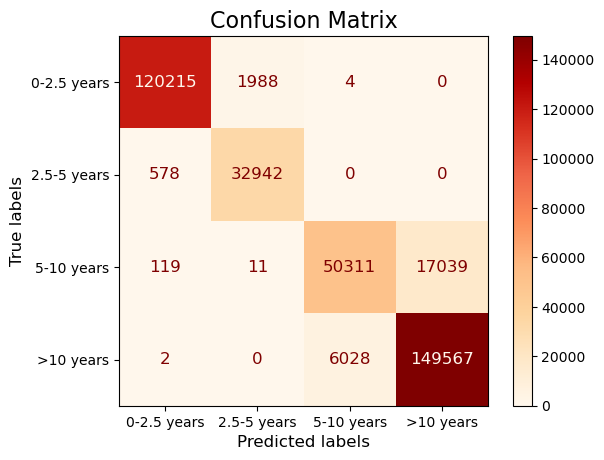

In [121]:
# predictions on train set
y_pred_train_encoded = xg.predict(train_X)

# Inverse transform the encoded predictions to get original labels
y_pred_train = label_encoder.inverse_transform(y_pred_train_encoded)

# Define your desired order of labels
desired_order = ['0-2.5 years', '2.5-5 years', '5-10 years', '>10 years']

# Convert desired_order to encoded if not already done
desired_order_encoded = label_encoder.transform(desired_order)
desired_order_encoded = list(desired_order_encoded)

# Sorting xg.classes_ using the encoded desired order
xg_sorted_labels = sorted(xg.classes_, key=lambda x: desired_order_encoded.index(x))

# Decode labels for human-readable format in plotting
display_labels = label_encoder.inverse_transform(xg_sorted_labels)

# confusion matrix
cm = confusion_matrix(train_y, y_pred_train, labels=display_labels)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=display_labels)

fig, ax = plt.subplots()
disp.plot(cmap = 'OrRd', ax = ax, values_format='d')
for texts in disp.text_:
    for text in texts:
        text.set_fontsize(12)  # Set the font size here

# Increase font size for labels and title
ax.set_xlabel('Predicted labels', fontsize=12)  # Set font size for x-axis label
ax.set_ylabel('True labels', fontsize=12)       # Set font size for y-axis label
ax.set_title('Confusion Matrix', fontsize=16)   # Set font size for the title

# Increase font size for the tick labels
plt.xticks(fontsize=10)  # Set font size for x-axis tick labels
plt.yticks(fontsize=10)  # Set font size for y-axis tick labels
plt.savefig('xgb_train_cm.svg')

In [89]:
print("Classification Report - \n",
      classification_report(train_y, y_pred_train))

Classification Report - 
               precision    recall  f1-score   support

 0-2.5 years       0.99      0.98      0.99    122207
 2.5-5 years       0.94      0.98      0.96     33520
  5-10 years       0.89      0.75      0.81     67480
   >10 years       0.90      0.96      0.93    155597

    accuracy                           0.93    378804
   macro avg       0.93      0.92      0.92    378804
weighted avg       0.93      0.93      0.93    378804



In [90]:
# Generating Classification Report
report = classification_report(train_y, y_pred_train, output_dict = True)
report_df = pd.DataFrame(report)
report_df.to_csv('xgb_train_class_report.csv')

In [122]:
# Predictions on test set
y_pred_encoded = xg.predict(test_X)

# Inverse transform the encoded predictions to get original labels
y_pred = label_encoder.inverse_transform(y_pred_encoded)

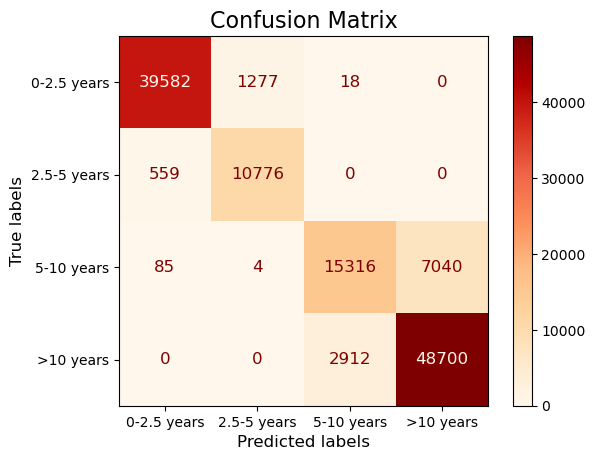

In [123]:
# Predictions on test set
y_pred_encoded = xg.predict(test_X)

# Inverse transform the encoded predictions to get original labels
y_pred = label_encoder.inverse_transform(y_pred_encoded)

cm = confusion_matrix(test_y, y_pred, labels=display_labels)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=display_labels)

fig, ax = plt.subplots()
disp.plot(cmap = 'OrRd', ax = ax, values_format='d')
for texts in disp.text_:
    for text in texts:
        text.set_fontsize(12)  # Set the font size here

# Increase font size for labels and title
ax.set_xlabel('Predicted labels', fontsize=12)  # Set font size for x-axis label
ax.set_ylabel('True labels', fontsize=12)       # Set font size for y-axis label
ax.set_title('Confusion Matrix', fontsize=16)   # Set font size for the title

# Increase font size for the tick labels
plt.xticks(fontsize=10)  # Set font size for x-axis tick labels
plt.yticks(fontsize=10)  # Set font size for y-axis tick labels
plt.savefig('xgb_test_cm.svg')

In [93]:
print("Classification Report - \n",
      classification_report(test_y, y_pred))

Classification Report - 
               precision    recall  f1-score   support

 0-2.5 years       0.98      0.97      0.98     40877
 2.5-5 years       0.89      0.95      0.92     11335
  5-10 years       0.84      0.68      0.75     22445
   >10 years       0.87      0.94      0.91     51612

    accuracy                           0.91    126269
   macro avg       0.90      0.89      0.89    126269
weighted avg       0.91      0.91      0.90    126269



In [94]:
# Generating Classification Report
report = classification_report(test_y, y_pred, output_dict = True)
report_df = pd.DataFrame(report)
report_df.to_csv('xgb_test_class_report.csv')

In [95]:
importance = xg.feature_importances_

feature_imp = pd.DataFrame(list(zip(train_X.columns, importance)),
               columns = ['Feature', 'Importance'])

feature_imp = feature_imp.sort_values('Importance', ascending = False).reset_index(drop = True)

feature_imp

,Feature,Importance
0,COUNTRY_OF_CITIZENSHIP_INDIA,0.718202
1,COUNTRY_OF_CITIZENSHIP_TAIWAN,0.106524
2,COUNTRY_OF_CITIZENSHIP_CHINA,0.096228
3,COUNTRY_OF_CITIZENSHIP_SOUTH KOREA,0.016993
4,JOB_INFO_EXPERIENCE_N,0.005163
...,...,...
351,COUNTRY_OF_CITIZENSHIP_LEBANON,0.000000
352,COUNTRY_OF_CITIZENSHIP_LIBERIA,0.000000
353,COUNTRY_OF_CITIZENSHIP_LIBYA,0.000000
354,COUNTRY_OF_CITIZENSHIP_LIECHTENSTEIN,0.000000


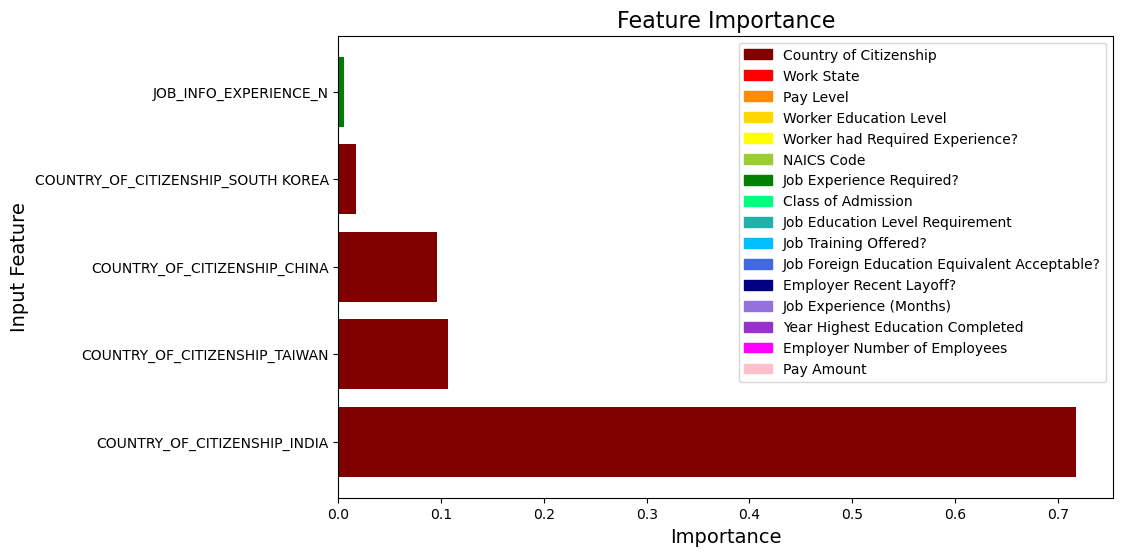

In [96]:

# Define categories and their respective feature lists
categories = {
    'COUNTRY_OF_CITIZENSHIP': [],
    'STATE': [],
    'PW_LEVEL': [],
    'FOREIGN_WORKER_INFO_EDUCATION': [],
    'FW_INFO_REQ_EXPERIENCE': [],
    'NAICS': [],
    'CLASS_OF': [],
    'JOB_INFO_EDUCATION': [],
    'JOB_INFO_TRAINING': [],
    'JOB_INFO_FOREIGN_ED': [],
    'RI_LAYOFF': [],
    'JOB_INFO_EXPERIENCE_NUM_MONTHS': [],
    'FW_INFO_YR_REL_EDU_COMPLETED': [],
    'EMPLOYER_NUM_EMPLOYEES': [],
    'JOB_INFO_EXPERIENCE': [],
    'PW_AMOUNT_9089': []
}

# Iterate over categories to populate the feature lists
for category in categories.keys():
    categories[category] = feature_imp[feature_imp['Feature'].str.contains(category)]['Feature'].tolist()

# Create a color map for categories
color_map = {
    'COUNTRY_OF_CITIZENSHIP': 'maroon',
    'STATE': 'red',
    'PW_LEVEL': 'darkorange',
    'FOREIGN_WORKER_INFO_EDUCATION': 'gold',
    'FW_INFO_REQ_EXPERIENCE': 'yellow',
    'NAICS': 'yellowgreen',
    'JOB_INFO_EXPERIENCE': 'green',
    'CLASS_OF': 'springgreen',
    'JOB_INFO_EDUCATION': 'lightseagreen',
    'JOB_INFO_TRAINING': 'deepskyblue',
    'JOB_INFO_FOREIGN_ED': 'royalblue',
    'RI_LAYOFF': 'navy',
    'JOB_INFO_EXPERIENCE_NUM_MONTHS': 'mediumpurple',
    'FW_INFO_YR_REL_EDU_COMPLETED': 'darkorchid',
    'EMPLOYER_NUM_EMPLOYEES': 'magenta',
    'PW_AMOUNT_9089': 'pink'
}

# Color each feature based on its category
colors = []
for feature in feature_imp['Feature']:
    for category, feature_list in categories.items():
        if feature in feature_list:
            colors.append(color_map[category])
            break
    else:
        colors.append('gray')  # default color for features not belonging to any category

# Selecting features with specific threshold for importance values
feature_imp_nonzero = feature_imp[feature_imp['Importance'] > 0.005]

display_names = {
    'COUNTRY_OF_CITIZENSHIP': 'Country of Citizenship',
    'STATE': 'Work State',
    'PW_LEVEL': 'Pay Level',
    'FOREIGN_WORKER_INFO_EDUCATION': 'Worker Education Level',
    'FW_INFO_REQ_EXPERIENCE': 'Worker had Required Experience?',
    'NAICS': 'NAICS Code',
    'JOB_INFO_EXPERIENCE': 'Job Experience Required?',
    'CLASS_OF': 'Class of Admission',
    'JOB_INFO_EDUCATION': 'Job Education Level Requirement',
    'JOB_INFO_TRAINING': 'Job Training Offered?',
    'JOB_INFO_FOREIGN_ED': 'Job Foreign Education Equivalent Acceptable?',
    'RI_LAYOFF': 'Employer Recent Layoff?',
    'JOB_INFO_EXPERIENCE_NUM_MONTHS': 'Job Experience (Months)',
    'FW_INFO_YR_REL_EDU_COMPLETED': 'Year Highest Education Completed',
    'EMPLOYER_NUM_EMPLOYEES': 'Employer Number of Employees',
    'PW_AMOUNT_9089': 'Pay Amount'
}

# Bar plot with colored bars
plt.figure(figsize=(10, 6), dpi=100)
bars = plt.barh(feature_imp_nonzero['Feature'], feature_imp_nonzero['Importance'], color=colors)

# Additional plot configurations
plt.xlabel("Importance", fontsize=14)
plt.ylabel("Input Feature", fontsize=14)
plt.title("Feature Importance", fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add legend for categories
legend_handles = [plt.Rectangle((0,0),1,1, color=color) for color in color_map.values()]
plt.legend(legend_handles, [display_names.get(category, category) for category in color_map.keys()], loc='upper right')

plt.savefig('xgb_importance_ind.svg')

plt.show()

In [97]:
# Aggregate Feature Importances
country_features = feature_imp[feature_imp['Feature'].str.contains('COUNTRY_OF_CITIZENSHIP')]
country_importance = country_features['Importance'].sum()

work_state_features = feature_imp[feature_imp['Feature'].str.contains('STATE')]
work_state_importance = work_state_features['Importance'].sum()

pay_features = feature_imp[feature_imp['Feature'].str.contains('PW_LEVEL')]
pay_importance = pay_features['Importance'].sum()

edu_features = feature_imp[feature_imp['Feature'].str.contains('FOREIGN_WORKER_INFO_EDUCATION')]
edu_importance = edu_features['Importance'].sum()

fw_req_exp_features = feature_imp[feature_imp['Feature'].str.contains('FW_INFO_REQ_EXPERIENCE')]
fw_req_exp_importance = fw_req_exp_features['Importance'].sum()

naics_features = feature_imp[feature_imp['Feature'].str.contains('NAICS')]
naics_importance = naics_features['Importance'].sum()

job_exp_features = feature_imp[feature_imp['Feature'].str.contains('JOB_INFO_EXPERIENCE')]
job_exp_importance = job_exp_features['Importance'].sum()

class_features = feature_imp[feature_imp['Feature'].str.contains('CLASS_OF')]
class_importance = class_features['Importance'].sum()

job_edu_features = feature_imp[feature_imp['Feature'].str.contains('JOB_INFO_EDUCATION')]
job_edu_importance = job_edu_features['Importance'].sum()

job_train_features = feature_imp[feature_imp['Feature'].str.contains('JOB_INFO_TRAINING')]
job_train_importance = job_train_features['Importance'].sum()

job_foreign_edu_features = feature_imp[feature_imp['Feature'].str.contains('JOB_INFO_FOREIGN_ED')]
job_foreign_edu_importance = job_foreign_edu_features['Importance'].sum()

layoff_features = feature_imp[feature_imp['Feature'].str.contains('RI_LAYOFF')]
layoff_importance = layoff_features['Importance'].sum()

In [98]:
# Extracting the importance values directly from the DataFrame
employer_num_employees_importance = feature_imp[feature_imp['Feature'] == 'EMPLOYER_NUM_EMPLOYEES']['Importance'].sum()
fw_info_yr_rel_edu_completed_importance = feature_imp[feature_imp['Feature'] == 'FW_INFO_YR_REL_EDU_COMPLETED']['Importance'].sum()
job_info_experience_num_months_importance = feature_imp[feature_imp['Feature'] == 'JOB_INFO_EXPERIENCE_NUM_MONTHS']['Importance'].sum()

# Create a dictionary with feature names as keys and their summed importance as values
data = {
    'Country of Citizenship': country_importance,
    'Work State': work_state_importance,
    'Pay Level': pay_importance,
    'Worker Education Level': edu_importance,
    'Worker has Required Experience?': fw_req_exp_importance,
    'NAICS Code': naics_importance,
    'Job Experience Required?': job_exp_importance,
    'Class of Admission': class_importance,
    'Job Education Level Requirement': job_edu_importance,
    'Job Training Offered?': job_train_importance,
    'Job Foreign Education Equivalent Acceptable?': job_foreign_edu_importance,
    'Employer Recent Layoff?': layoff_importance,
    'Employer Number of Employees': employer_num_employees_importance,
    'Year Highest Education Completed': fw_info_yr_rel_edu_completed_importance,
    'Job Experience (Months)': job_info_experience_num_months_importance
}

# Convert dictionary to DataFrame
feature_importances = pd.DataFrame(list(data.items()), columns=['Feature', 'Importance'])

feature_importances

,Feature,Importance
0,Country of Citizenship,0.944575
1,Work State,0.015520
2,Pay Level,0.001568
3,Worker Education Level,0.005601
4,Worker has Required Experience?,0.004849
5,NAICS Code,0.007191
6,Job Experience Required?,0.006170
7,Class of Admission,0.007294
8,Job Education Level Requirement,0.002737
9,Job Training Offered?,0.000371


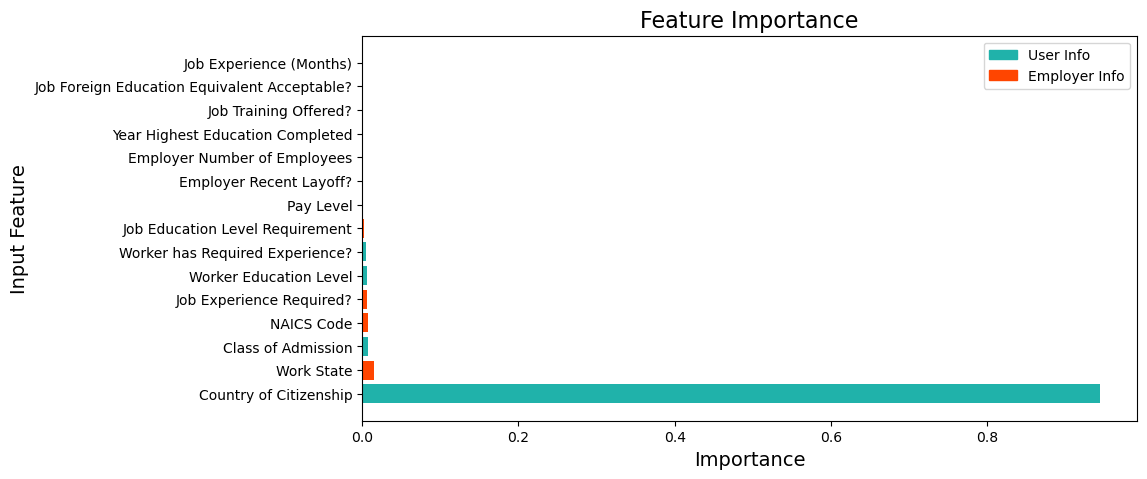

In [99]:
# Define categories and their corresponding colors
category_colors = {
    'User Info': 'lightseagreen',
    'Employer Info': 'orangered'
}

# Create a function to categorize features
def categorize_feature(feature_name):
    user_info_features = ['Country of Citizenship', 'Worker Education Level', 'Worker has Required Experience?', 'Class of Admission', 'Year Highest Education Completed']
    if feature_name in user_info_features:
        return 'User Info'
    else:
        return 'Employer Info'

# Apply the function to categorize each feature and create a new column in feature_importances DataFrame
feature_importances['Category'] = feature_importances['Feature'].apply(categorize_feature)

# Sort features by importance in ascending order
feature_importances_sorted = feature_importances.sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 5), dpi=100)
for index, row in feature_importances_sorted.iterrows():
    plt.barh(row['Feature'], row['Importance'], color=category_colors[row['Category']])

plt.xlabel("Importance", fontsize=14)
plt.ylabel("Input Feature", fontsize=14)
plt.title("Feature Importance", fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Create legend
handles = [plt.Rectangle((0,0),1,1, color=color) for color in category_colors.values()]
plt.legend(handles, category_colors.keys(), loc='upper right')

plt.savefig('xgb_importance.svg')

In [124]:
f1_xgb = f1_score(test_y, y_pred, average='macro')
f1_weighted_xgb = f1_score(test_y, y_pred, average='weighted')
accuracy_xgb = accuracy_score(test_y, y_pred)

In [126]:
results = pd.DataFrame({
    'Model': ['Decision Tree', 'Random Forest', 'AdaBoost', 'XGBoost'],
    'f-1 Score Macro Average': [f1_dt, f1_rf, f1_ada, f1_xgb],
    'f-1 Score Weighted Average': [f1_weighted_dt, f1_weighted_rf, f1_weighted_ada, f1_weighted_xgb],
    'Accuracy': [accuracy_dt, accuracy_rf, accuracy_ada, accuracy_xgb]
})
results = results.sort_values(by='f-1 Score Macro Average', ascending=False)
# Save the DataFrame to a CSV file
results.to_csv('model_f1_scores.csv', index=False)

# Print the DataFrame
print(results)

           Model  f-1 Score Macro Average  f-1 Score Weighted Average  \
2       AdaBoost                 0.915449                    0.924818   
3        XGBoost                 0.889381                    0.903365   
0  Decision Tree                 0.867605                    0.883941   
1  Random Forest                 0.820125                    0.846691   

   Accuracy  
2  0.926276  
3  0.905796  
0  0.884184  
1  0.858382  
